## Quantum Grover Oracle Evolution with Grammatical Evolution

## Imports and Dependencies

In [ ]:
# Standard Library Imports
import os
import re
import json
import random
import multiprocessing
from typing import Any, Tuple
import glob
from datetime import datetime
import time
import logging

# Third-party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_distribution
from IPython.display import display
from deap import creator, base, tools

import grape  # Grammatical evolution library
from grape import algorithms  # Evolutionary algorithms


In [2]:
logger = logging.getLogger(__name__)

## IBM Quantum Service Configuration

In [ ]:
# Configure IBM Quantum Service
QiskitRuntimeService.save_account(
    token='', 
    overwrite=True,
    channel='ibm_cloud',
    instance='crn:v1::public:::'
)
service = QiskitRuntimeService(name="qgss-2025")
backend = service.backend("ibm_torino")
backend_name = backend.name
print(f"✓ Connected to backend: {backend_name}")

✓ Connected to backend: ibm_brisbane


## Core Configuration

In [ ]:
# === CORE CONFIGURATION ===
# Target state for Grover's algorithm
TARGET_STATE = "000"

# Random seed configuration
USE_FIXED_SEED = True    # Set to False for random initialization

# Set random seed
if USE_FIXED_SEED:
    RANDOM_SEED = 78472
    print(f"Using fixed seed: {RANDOM_SEED}")
else:
    RANDOM_SEED = int(time.time()) % 100000
    print(f"Using random seed: {RANDOM_SEED}")
    with open('last_random_seed.txt', 'w') as f:
        f.write(str(RANDOM_SEED))

# Apply seed
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"\n=== CONFIGURATION ===")
print(f"Target State: {TARGET_STATE}")
print(f"Backend: {backend_name}")

Using random seed: 78472

=== CONFIGURATION ===
Target State: 000
Backend: ibm_brisbane


## Directory Setup

In [5]:
# Set up logging directory
LOG_DIR = f"logs_marked_state_IBM_{TARGET_STATE}_ibm_brisbane"
os.makedirs(LOG_DIR, exist_ok=True)
print(f"Logs will be saved to: {LOG_DIR}")

Logs will be saved to: logs_marked_state_IBM_000_ibm_brisbane


## Evolution Parameters

In [6]:
# === EVOLUTION PARAMETERS ===
POPULATION_SIZE    = 1000
MAX_GENERATIONS    = 100
N_GEN = 1
P_CROSSOVER        = 0.8     
P_MUTATION         = 0.01
ELITE_SIZE         = 1
HALLOFFAME_SIZE    = 1
CODON_SIZE         = 400
MAX_TREE_DEPTH     = 50      
TOURNAMENT_SIZE    = 5
MIN_INIT_DEPTH     = 20        
MAX_INIT_DEPTH     = 40       
CODON_CONSUMPTION  = "lazy"   
GENOME_REPRESENTATION = 'list'

# Evaluation Constants
NUM_SHOTS = 10000
SUCCESS_THRESHOLD = 0.48
GATE_PENALTY_WEIGHT = 0.02

print(f"\n=== EVOLUTION PARAMETERS ===")
print(f"Population: {POPULATION_SIZE}")
print(f"Generations: {MAX_GENERATIONS}")
print(f"Crossover: {P_CROSSOVER}")
print(f"Mutation: {P_MUTATION}")
print(f"Shots: {NUM_SHOTS}")


=== EVOLUTION PARAMETERS ===
Population: 1000
Generations: 100
Crossover: 0.8
Mutation: 0.01
Shots: 10000


## Hardware Setup

In [7]:
# === HARDWARE SETUP ===
num_cores = os.cpu_count()
print(f"\n=== HARDWARE ===")
print(f"CPU cores available: {num_cores}")

# Initialize simulator
simulator = QasmSimulator()
print("✓ Using QasmSimulator (ideal simulation)")


=== HARDWARE ===
CPU cores available: 8
✓ Using QasmSimulator (ideal simulation)


## Grammar and Circuit Evaluation

In [8]:
# Load BNF Grammar
BNF_GRAMMAR = grape.Grammar("grammars/grover.bnf")
print("✓ Grammar loaded")

✓ Grammar loaded


In [9]:
def generate_oracle_for_state(marked_state: str) -> str:
    """Generate Grover oracle code for a given marked state."""
    n = len(marked_state)
    code_lines = []
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    code_lines.append(f"qc.h({n-1})")
    code_lines.append(f"qc.mcx(list(range({n-1})), {n-1})")
    code_lines.append(f"qc.h({n-1})")
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    return "\n".join(code_lines) + "\n"


In [10]:
class CircuitEvaluator:
    def __init__(self, shots: int = NUM_SHOTS, log_dir: str = LOG_DIR, seed: int = None):
        self.shots = shots
        self.log_dir = log_dir
        self.seed = seed if seed is not None else RANDOM_SEED
        os.makedirs(self.log_dir, exist_ok=True)
    
    def decode_individual(self, ind) -> str:
        if ind.invalid or not hasattr(ind, 'phenotype'):
            return None
        try:
            if isinstance(ind.phenotype, list):
                code = ''.join(ind.phenotype)
            else:
                code = ind.phenotype
            code = code.replace('"', '')
            code = code.replace('\\n', '\n')
            
            # Fix circuit initialization for SamplerV2 compatibility
            match = re.search(r'qc\s*=\s*QuantumCircuit\((\d+),\s*(\d+)\)', code)
            if match:
                n_qubits = match.group(1)
                n_clbits = match.group(2)
                old_init = match.group(0)
                new_init = f"qr = QuantumRegister({n_qubits}, name='q')\ncr = ClassicalRegister({n_clbits}, name='cr')\nqc = QuantumCircuit(qr, cr)"
                code = code.replace(old_init, new_init, 1)
            
            code = '\n'.join(line.lstrip() for line in code.split('\n'))
            return code
        except Exception as ex:
            print(f"[Decode Error] {ex}")
            return None
    
    def execute_circuit(self, phenotype_code: str) -> QuantumCircuit:
        local_vars = {}
        try:
            exec(phenotype_code, globals(), local_vars)
            if "qc" in local_vars:
                return local_vars["qc"]
            else:
                print("No circuit variable 'qc' found in phenotype code.")
                return None
        except Exception as e:
            print(f"Error executing phenotype code: {e}")
            return None
    
    def simulate_circuit(self, circuit: QuantumCircuit, marked_state: str, individual_seed: int = None) -> dict:
        sim_seed = individual_seed if individual_seed is not None else self.seed
        try:
            # Run ideal simulation (no transpilation, no noise)
            result = simulator.run(circuit, shots=self.shots, seed_simulator=sim_seed).result()
            
            # Process counts
            counts = result.get_counts()
            corrected = {k[::-1]: v for k, v in counts.items()}
            total = sum(corrected.values())
            p_marked = corrected.get(marked_state, 0) / total if total > 0 else 0.0
            error = 1 - p_marked
            
            return {
                "counts": corrected,
                "p_marked": p_marked,
                "error": error,
                "gate_count": circuit.size(),
                "depth": circuit.depth()
            }
        except Exception as e:
            print(f"[Simulation Error] {e}")
            return {
                "counts": {},
                "p_marked": 0.0,
                "error": 1.0,
                "gate_count": 999,
                "depth": 999
            }
    
    def log_evaluation(self, logs: list, generation: int, individual) -> None:
        id_hash = hash(str(individual.genome)) % 10**8
        log_file_json = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.json")
        log_file_csv = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.csv")
        
        with open(log_file_json, "w") as f:
            json.dump(logs, f, indent=2)
        df = pd.DataFrame(logs)
        df[["state", "p_marked", "error", "gate_count", "depth"]].to_csv(log_file_csv, index=False)


In [11]:
def inject_oracle(phenotype_str: str, oracle_code: str) -> str:
    pattern = r"(## Begin Oracle\n)(.*?)(## End Oracle\n)"
    new_block = r"\1" + oracle_code + r"\3"
    return re.sub(pattern, new_block, phenotype_str, flags=re.DOTALL)


In [12]:
def fitness_function_qiskit(
    phenotype_str,
    shots=NUM_SHOTS,
    threshold=SUCCESS_THRESHOLD,
    gate_penalty_weight=GATE_PENALTY_WEIGHT,
    target_state=TARGET_STATE,
    log_states=True,
    individual_seed=None
):
    if not isinstance(phenotype_str, str):
        return (float('inf'), []) if log_states else float('inf')
    
    evaluator = CircuitEvaluator(shots=shots, seed=individual_seed)
    logs = []
    
    oracle_code = generate_oracle_for_state(target_state)
    modified_code = inject_oracle(phenotype_str, oracle_code)
    qc = evaluator.execute_circuit(modified_code)
    if qc is None:
        return (float('inf'), []) if log_states else float('inf')
    
    result = evaluator.simulate_circuit(qc, target_state, individual_seed=individual_seed)
    
    p_marked = result["p_marked"]
    error = 1 - p_marked
    miss = 1 if error > threshold else 0
    gate_count = result.get("gate_count", 0)
    depth = result.get("depth", 0)
    
    fitness_score = 10 * miss + error + gate_penalty_weight * gate_count
    
    if log_states:
        logs.append({
            "state": target_state,
            "p_marked": p_marked,
            "error": error,
            "gate_count": gate_count,
            "depth": depth,
            "oracle": oracle_code,
            "code": modified_code,
            "counts": result["counts"]
        })
        return (fitness_score, logs)
    else:
        return fitness_score

## DEAP Toolbox Setup

In [13]:
# Create DEAP types
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

# Setup toolbox
toolbox = base.Toolbox()
toolbox.register(
    "populationCreator",
    grape.sensible_initialisation,
    creator.Individual,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,  
    max_init_depth=MAX_INIT_DEPTH,  
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION,
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

# Setup multiprocessing
pool = multiprocessing.Pool(num_cores)
toolbox.register("map", pool.map)

In [14]:
# Setup evaluation
evaluator = CircuitEvaluator(shots=NUM_SHOTS, log_dir=LOG_DIR)
eval_counter = 0

def evaluate_with_logging(individual, pts_train=None):
    """Evaluation function with deterministic seeding."""
    global eval_counter
    
    genome_hash = hash(tuple(individual.genome)) if hasattr(individual, 'genome') else hash(str(individual))
    individual_seed = (RANDOM_SEED + genome_hash) % (2**32)
    
    evaluator = CircuitEvaluator(shots=NUM_SHOTS, log_dir=LOG_DIR, seed=individual_seed)
    phenotype_str = evaluator.decode_individual(individual)
    if not phenotype_str:
        return (float('inf'),)
    
    fitness_val, logs = fitness_function_qiskit(
        phenotype_str, 
        shots=NUM_SHOTS, 
        threshold=SUCCESS_THRESHOLD, 
        gate_penalty_weight=GATE_PENALTY_WEIGHT,
        target_state=TARGET_STATE, 
        log_states=True,
        individual_seed=individual_seed
    )
    gen = getattr(individual, "generation", "unknown")
    evaluator.log_evaluation(logs, gen, individual)
    eval_counter += 1
    return (fitness_val,)

toolbox.register("evaluate", evaluate_with_logging)


In [15]:
# Setup statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

print("✓ DEAP toolbox configured")

✓ DEAP toolbox configured


## Initialize Population

In [16]:
print(f"\n{'='*60}")
print("INITIALIZING EVOLUTION")
print(f"{'='*60}")

# Create random population
population = toolbox.populationCreator(
    pop_size=POPULATION_SIZE,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,
    max_init_depth=MAX_INIT_DEPTH,
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION
)

# Initialize tracking
hof = tools.HallOfFame(HALLOFFAME_SIZE)
generations_list = []
best_fitness_list = []
avg_gate_count_list = []

print(f"✓ Population created: {len(population)} individuals")
print(f"✓ Ready to evolve for {MAX_GENERATIONS} generations")



INITIALIZING EVOLUTION
✓ Population created: 1000 individuals
✓ Ready to evolve for 100 generations


## Run Evolution


STARTING EVOLUTION

gen = 0 , Best fitness = (11.165700000000001,)
gen = 1 , Best fitness = (11.1652,) , Number of invalids = 128

[Generation 0] Best Fitness: 11.1652
  Raw gates: 37, depth: 27
  p(marked): 0.1348
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


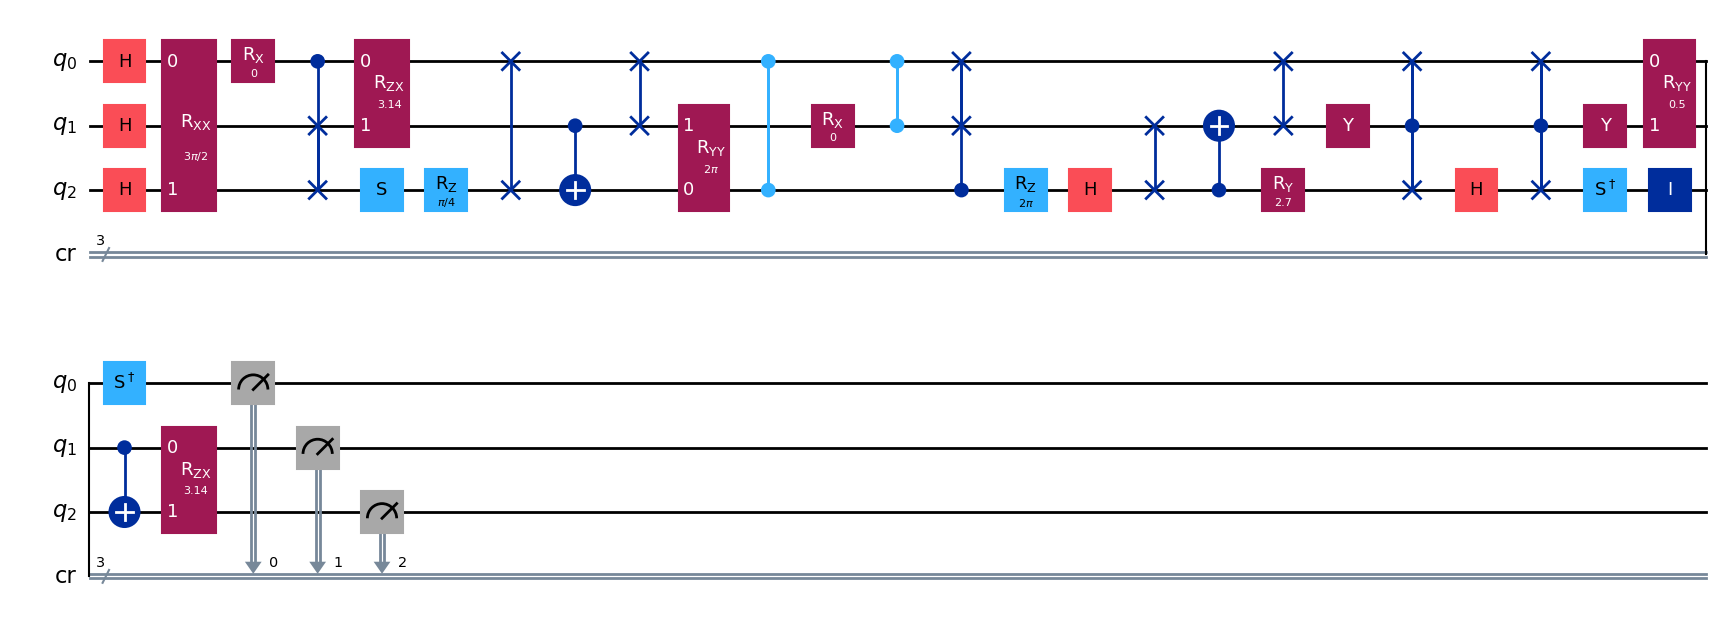

gen = 0 , Best fitness = (11.1652,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.164200000000001,) , Number of invalids = 62

[Generation 1] Best Fitness: 11.1642
  Raw gates: 13, depth: 9
  p(marked): 0.1358
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


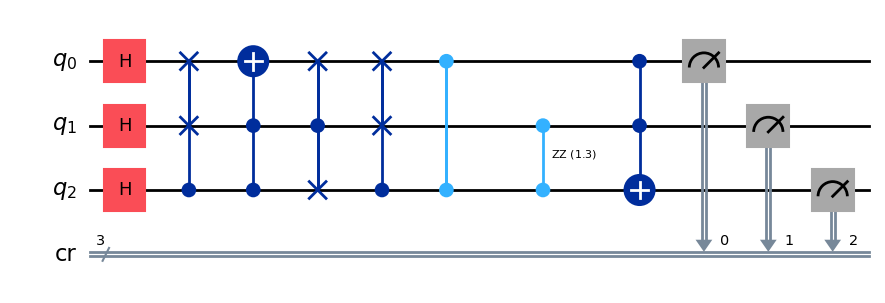

gen = 0 , Best fitness = (11.164200000000001,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.1402,) , Number of invalids = 38

[Generation 2] Best Fitness: 11.1402
  Raw gates: 32, depth: 19
  p(marked): 0.4998
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


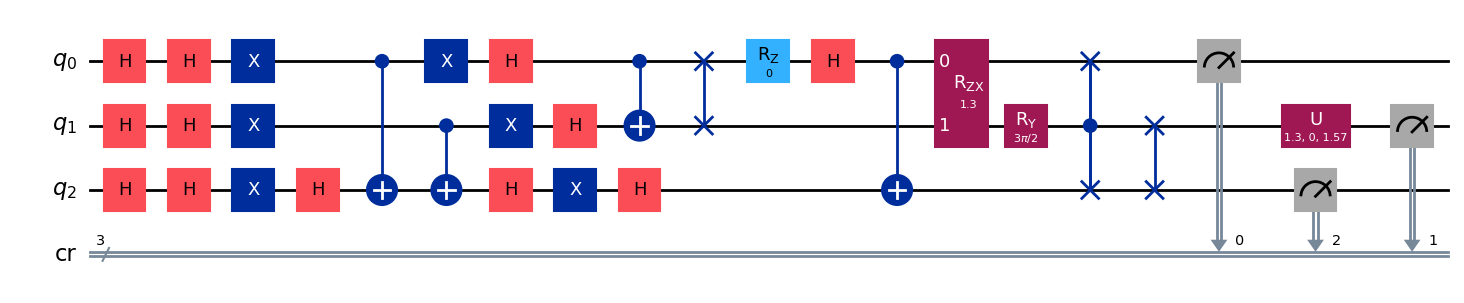

gen = 0 , Best fitness = (11.1402,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.1402,) , Number of invalids = 56

[Generation 3] Best Fitness: 11.1402
  Raw gates: 32, depth: 19
  p(marked): 0.4998
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


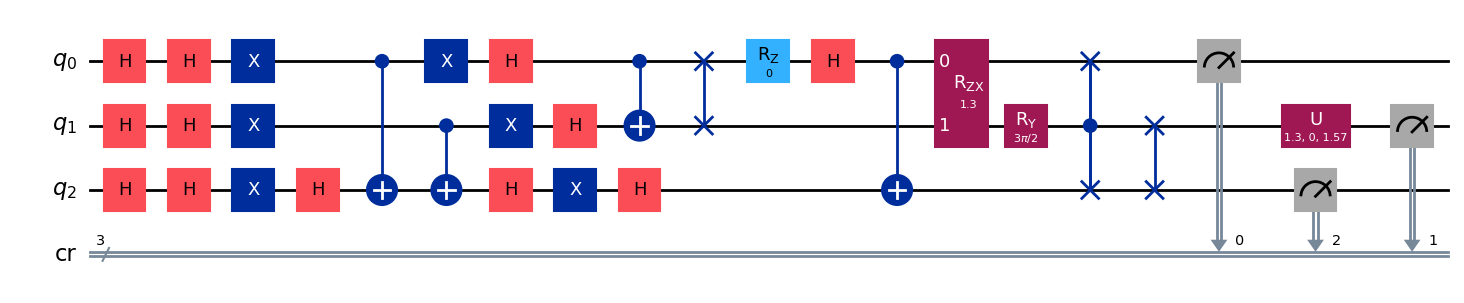

gen = 0 , Best fitness = (11.1402,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.1402,) , Number of invalids = 42

[Generation 4] Best Fitness: 11.1402
  Raw gates: 32, depth: 19
  p(marked): 0.4998
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


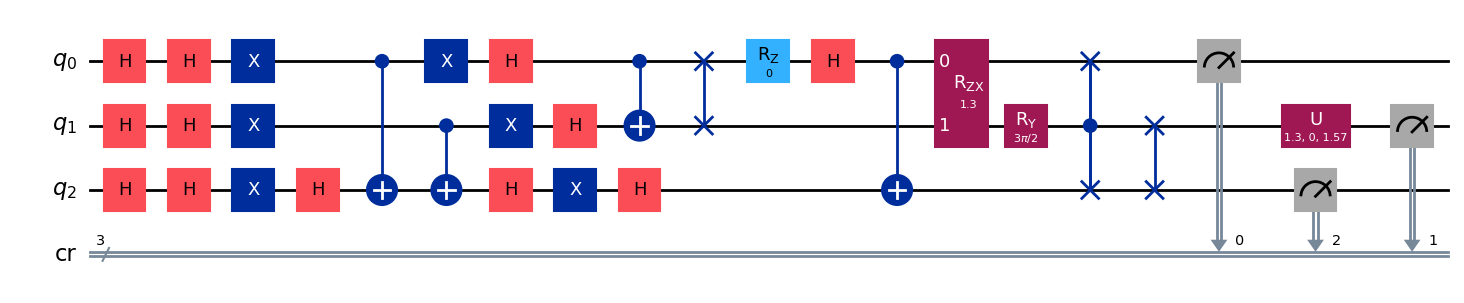

gen = 0 , Best fitness = (11.1402,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.138900000000001,) , Number of invalids = 31

[Generation 5] Best Fitness: 11.1389
  Raw gates: 32, depth: 19
  p(marked): 0.5011
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


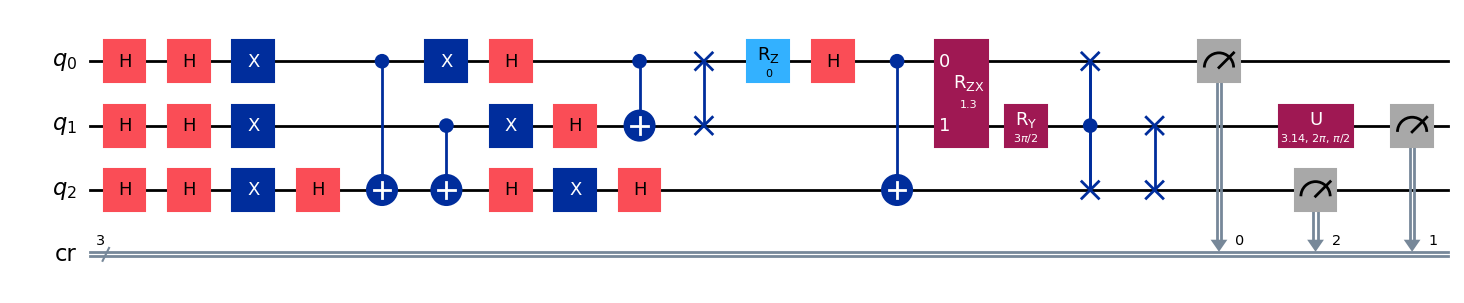

gen = 0 , Best fitness = (11.138900000000001,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.104099999999999,) , Number of invalids = 27

[Generation 6] Best Fitness: 11.1041
  Raw gates: 30, depth: 16
  p(marked): 0.4959
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


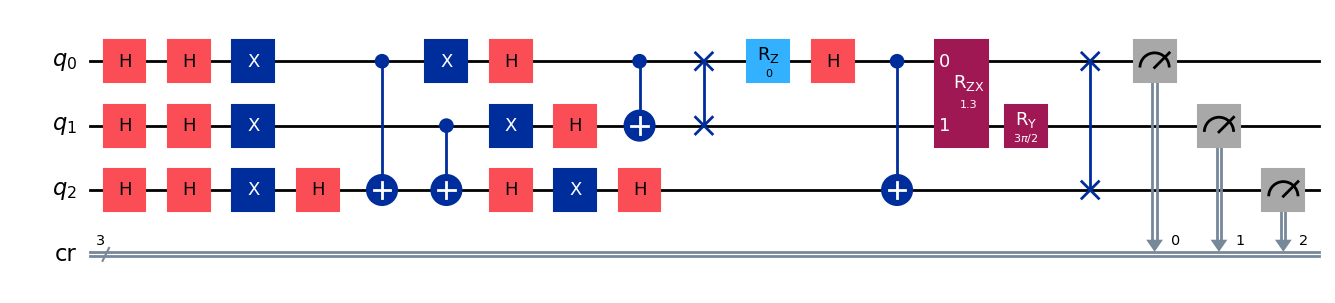

gen = 0 , Best fitness = (11.104099999999999,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.104099999999999,) , Number of invalids = 22

[Generation 7] Best Fitness: 11.1041
  Raw gates: 30, depth: 16
  p(marked): 0.4959
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


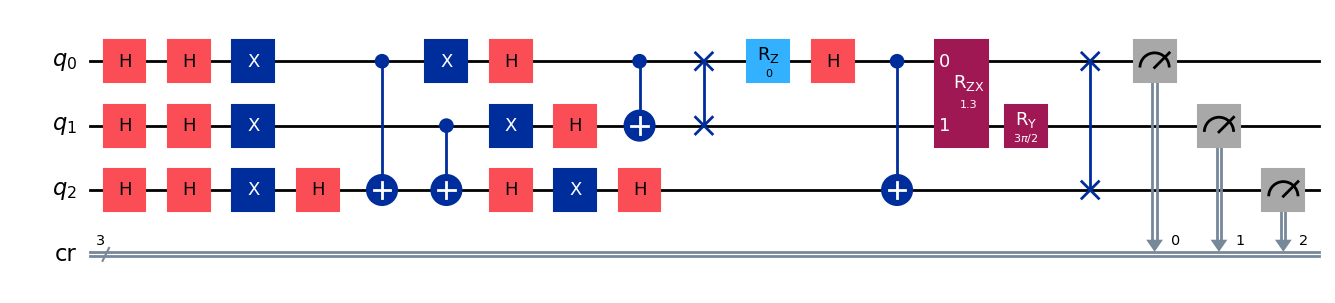

gen = 0 , Best fitness = (11.104099999999999,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.0785,) , Number of invalids = 19

[Generation 8] Best Fitness: 11.0785
  Raw gates: 29, depth: 15
  p(marked): 0.5015
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


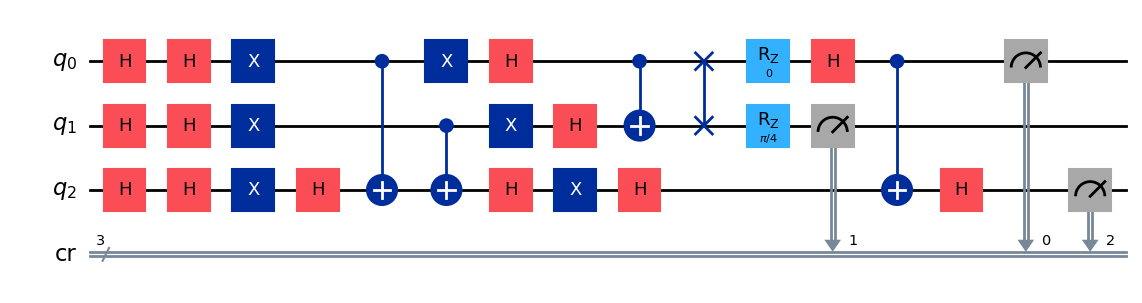

gen = 0 , Best fitness = (11.0785,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (11.078,) , Number of invalids = 23

[Generation 9] Best Fitness: 11.0780
  Raw gates: 29, depth: 15
  p(marked): 0.5020
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


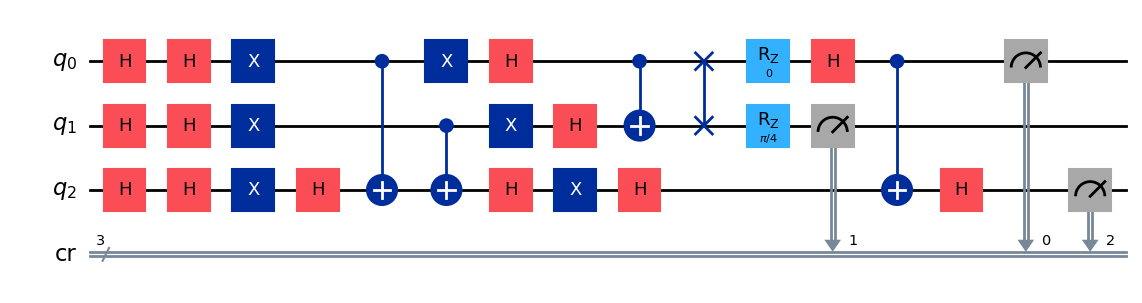

gen = 0 , Best fitness = (11.078,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (1.0582,) , Number of invalids = 18

[Generation 10] Best Fitness: 1.0582
  Raw gates: 34, depth: 19
  p(marked): 0.6218
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


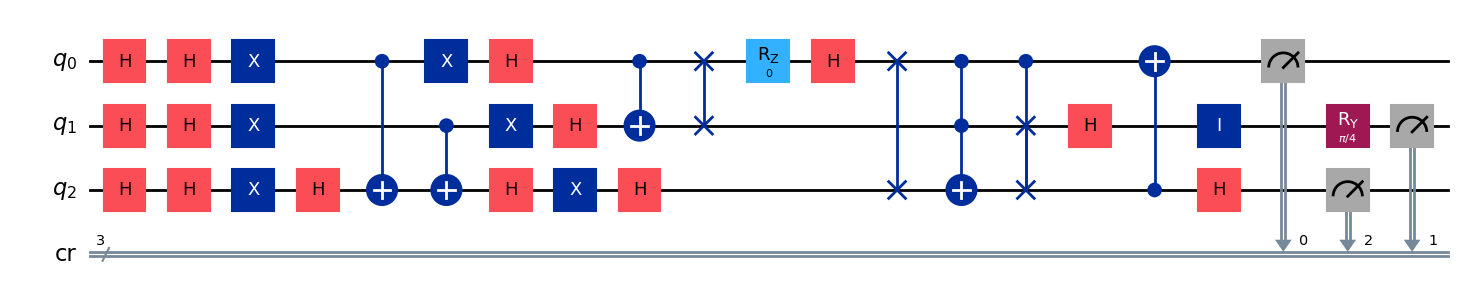

gen = 0 , Best fitness = (1.0582,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.6,) , Number of invalids = 19

[Generation 11] Best Fitness: 0.6000
  Raw gates: 30, depth: 16
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


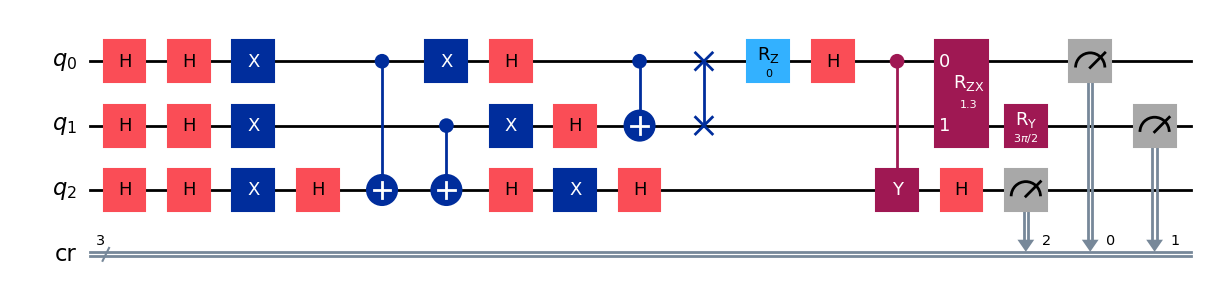

gen = 0 , Best fitness = (0.6,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.6,) , Number of invalids = 13

[Generation 12] Best Fitness: 0.6000
  Raw gates: 30, depth: 17
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


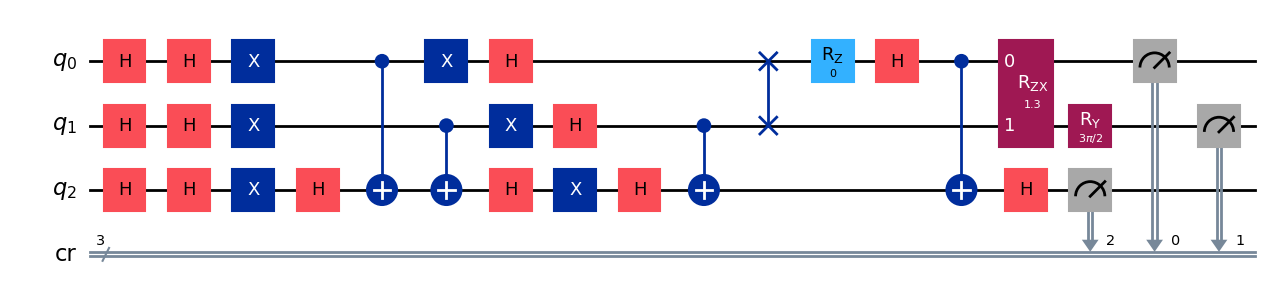

gen = 0 , Best fitness = (0.6,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.6,) , Number of invalids = 18

[Generation 13] Best Fitness: 0.6000
  Raw gates: 30, depth: 17
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


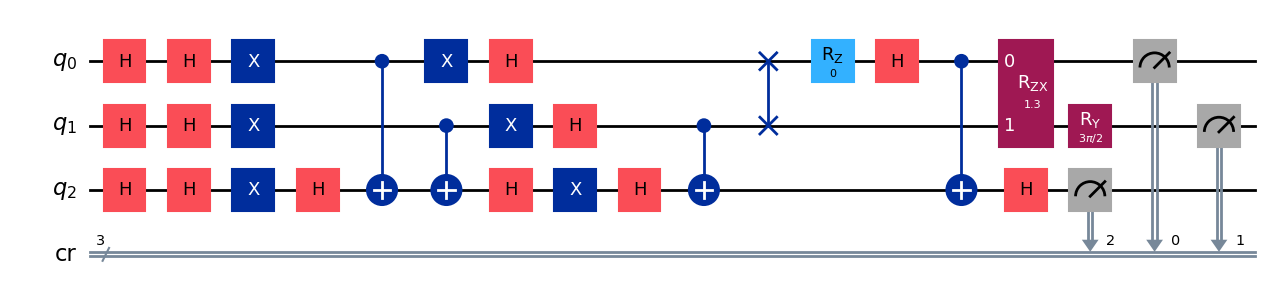

gen = 0 , Best fitness = (0.6,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.6,) , Number of invalids = 12

[Generation 14] Best Fitness: 0.6000
  Raw gates: 30, depth: 15
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


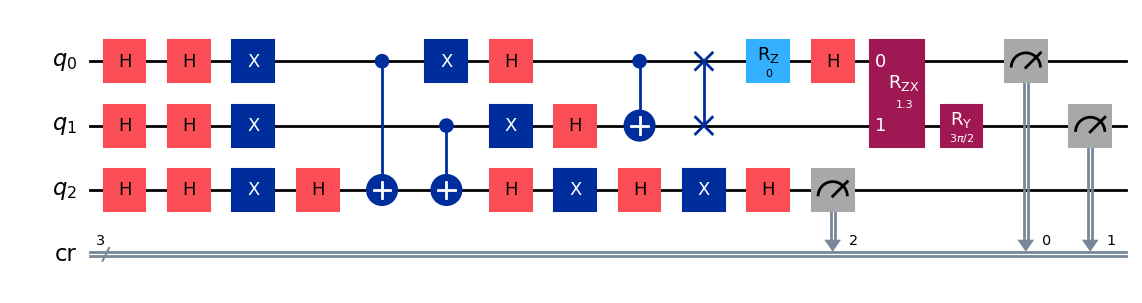

gen = 0 , Best fitness = (0.6,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.58,) , Number of invalids = 9

[Generation 15] Best Fitness: 0.5800
  Raw gates: 29, depth: 15
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


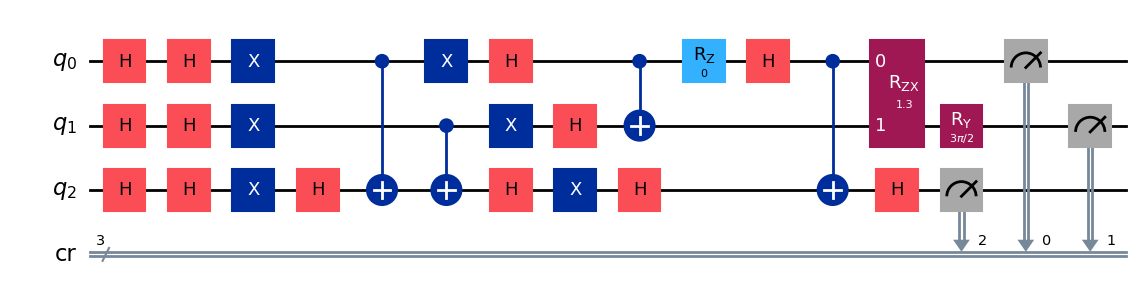

gen = 0 , Best fitness = (0.58,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.54,) , Number of invalids = 2

[Generation 16] Best Fitness: 0.5400
  Raw gates: 27, depth: 14
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


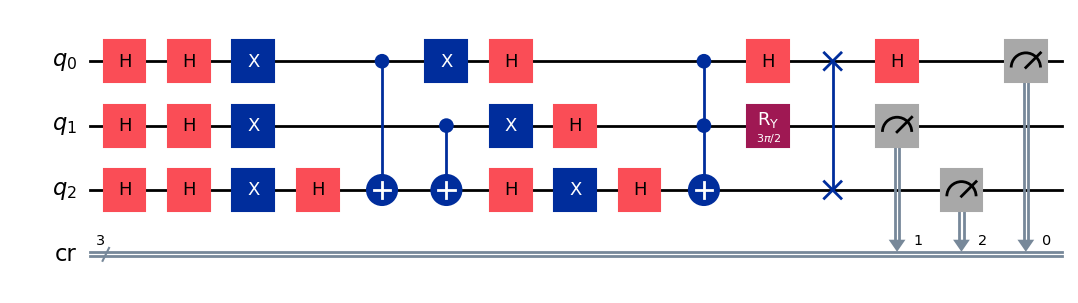

gen = 0 , Best fitness = (0.54,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.54,) , Number of invalids = 4

[Generation 17] Best Fitness: 0.5400
  Raw gates: 27, depth: 14
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


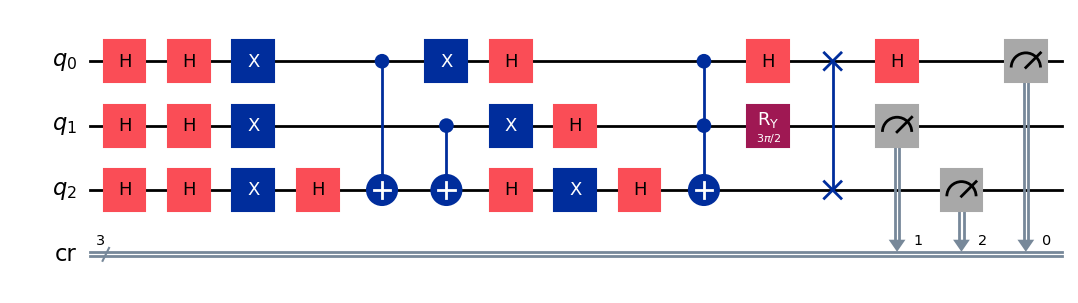

gen = 0 , Best fitness = (0.54,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.54,) , Number of invalids = 2

[Generation 18] Best Fitness: 0.5400
  Raw gates: 27, depth: 14
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


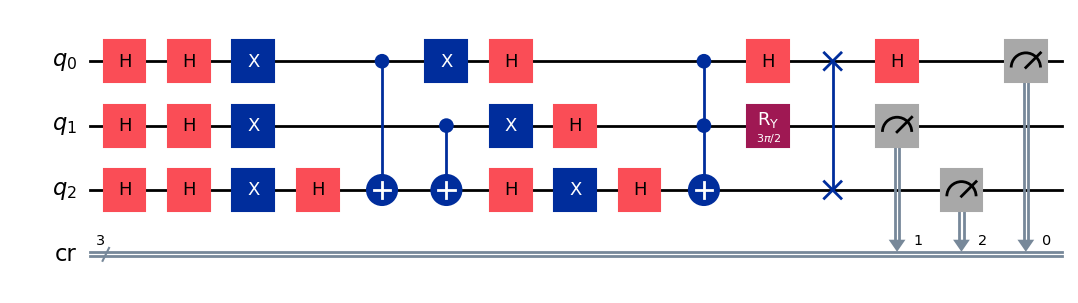

gen = 0 , Best fitness = (0.54,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.54,) , Number of invalids = 2

[Generation 19] Best Fitness: 0.5400
  Raw gates: 27, depth: 13
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


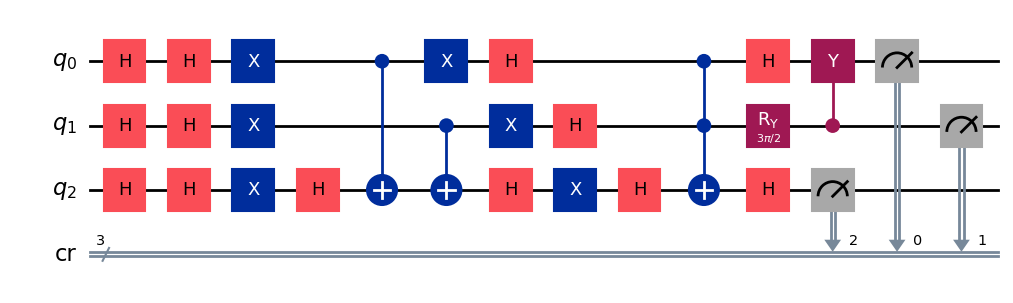

gen = 0 , Best fitness = (0.54,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.54,) , Number of invalids = 1

[Generation 20] Best Fitness: 0.5400
  Raw gates: 27, depth: 13
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


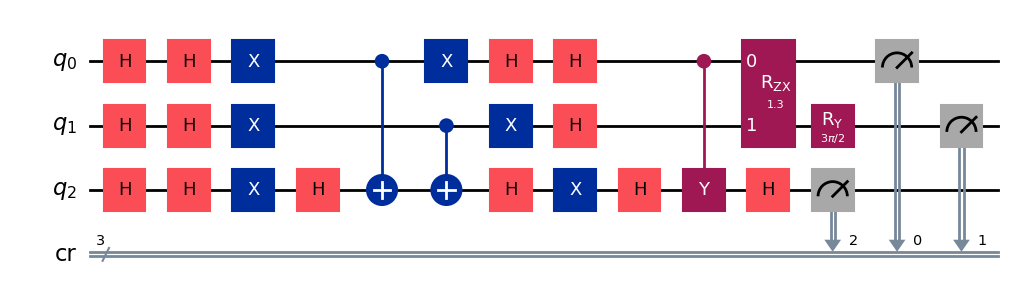

gen = 0 , Best fitness = (0.54,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.54,) , Number of invalids = 0

[Generation 21] Best Fitness: 0.5400
  Raw gates: 27, depth: 13
  p(marked): 1.0000
[Raw Circuit]


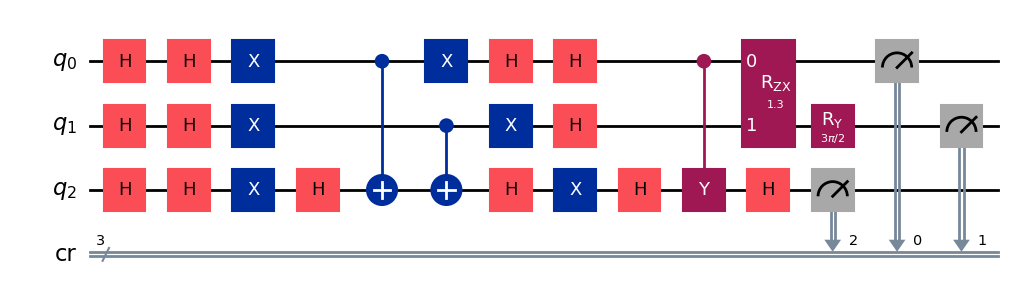

gen = 0 , Best fitness = (0.54,)
gen = 1 , Best fitness = (0.54,) , Number of invalids = 0

[Generation 22] Best Fitness: 0.5400
  Raw gates: 27, depth: 12
  p(marked): 1.0000
[Raw Circuit]


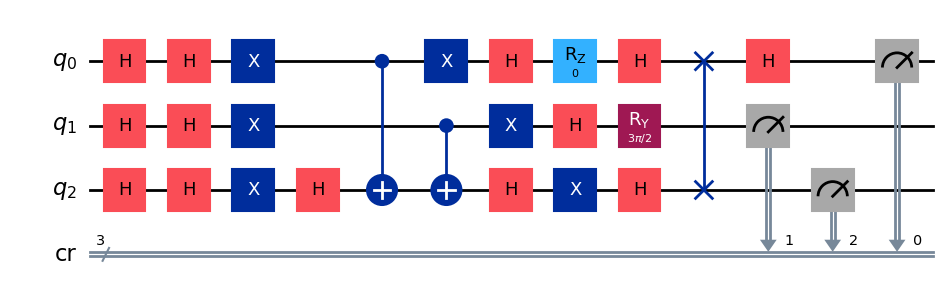

gen = 0 , Best fitness = (0.54,)
gen = 1 , Best fitness = (0.52,) , Number of invalids = 2

[Generation 23] Best Fitness: 0.5200
  Raw gates: 26, depth: 12
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


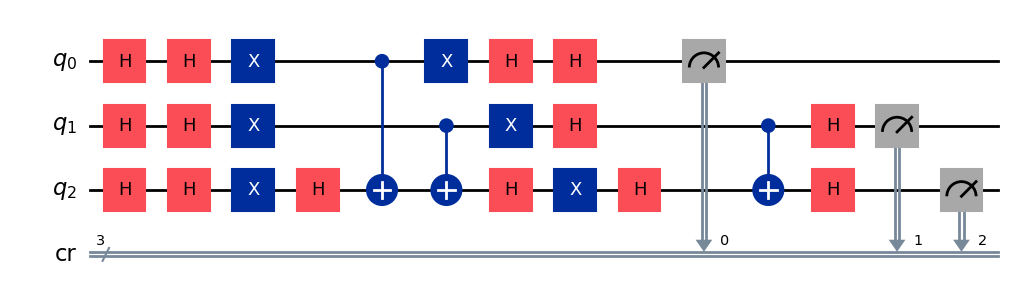

gen = 0 , Best fitness = (0.52,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.52,) , Number of invalids = 0

[Generation 24] Best Fitness: 0.5200
  Raw gates: 26, depth: 12
  p(marked): 1.0000
[Raw Circuit]


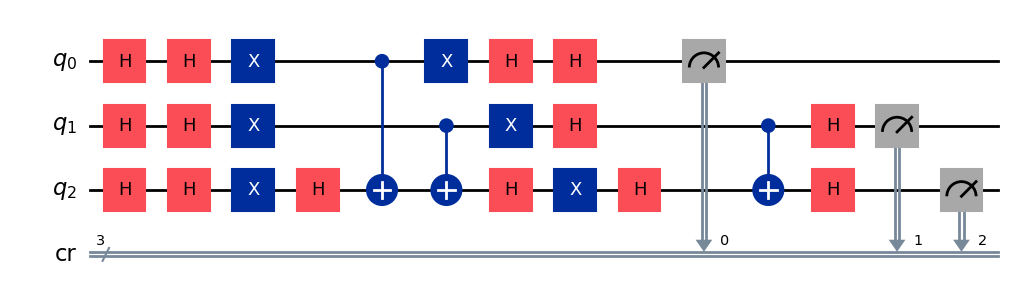

gen = 0 , Best fitness = (0.52,)
gen = 1 , Best fitness = (0.52,) , Number of invalids = 1

[Generation 25] Best Fitness: 0.5200
  Raw gates: 26, depth: 12
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


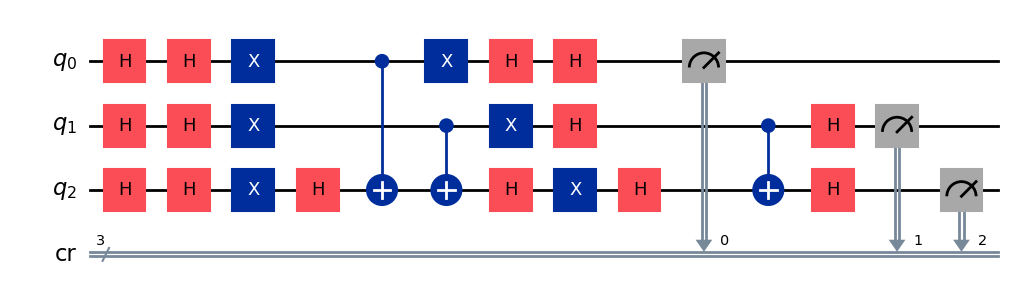

gen = 0 , Best fitness = (0.52,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 26] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


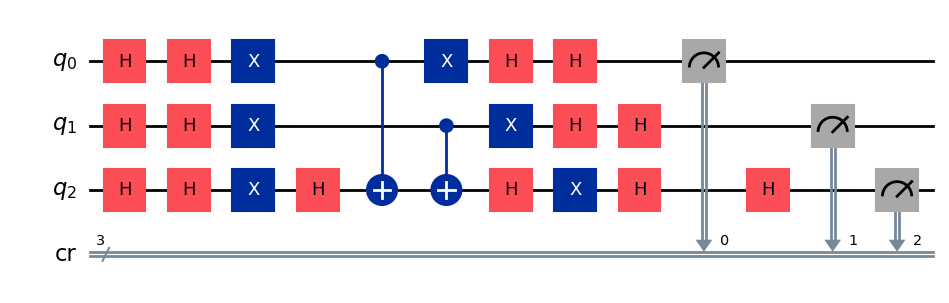

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 27] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


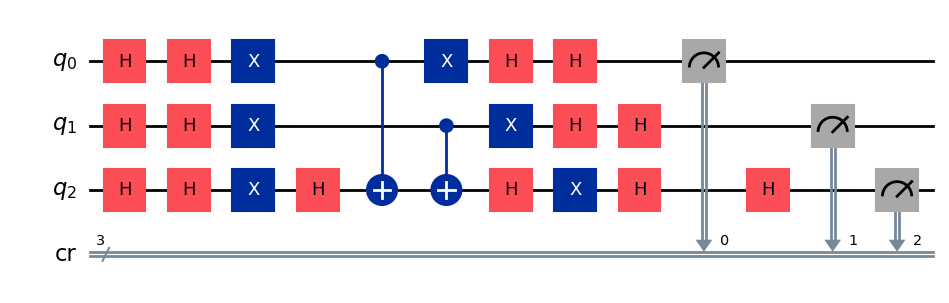

gen = 0 , Best fitness = (0.5,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 28] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


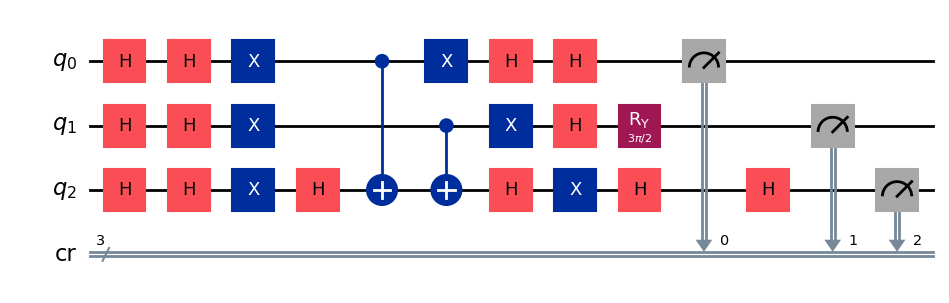

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 1

[Generation 29] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


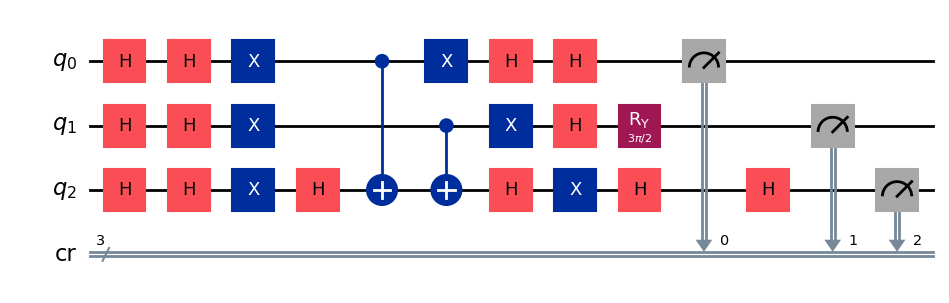

gen = 0 , Best fitness = (0.5,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.5,) , Number of invalids = 1

[Generation 30] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


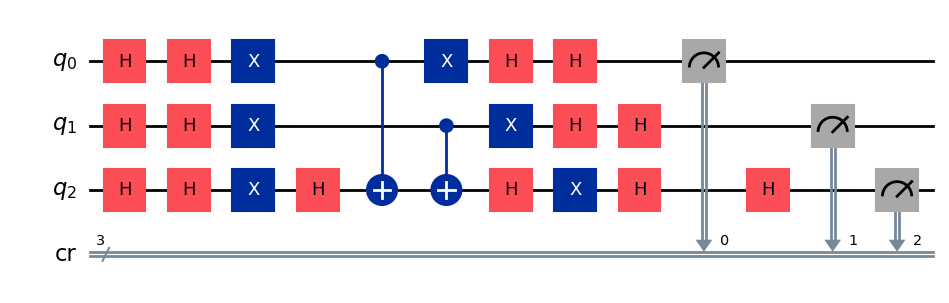

gen = 0 , Best fitness = (0.5,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.5,) , Number of invalids = 2

[Generation 31] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


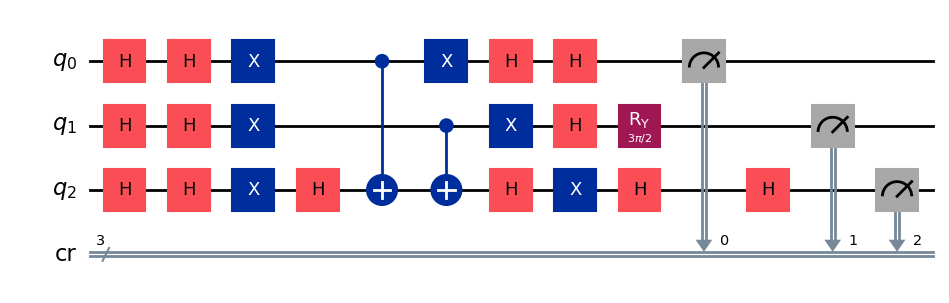

gen = 0 , Best fitness = (0.5,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.5,) , Number of invalids = 1

[Generation 32] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


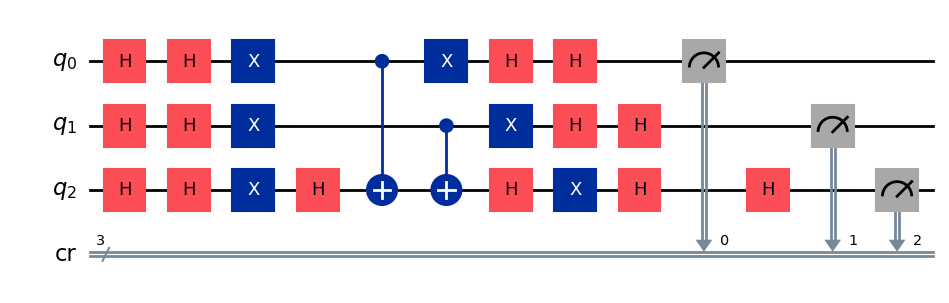

gen = 0 , Best fitness = (0.5,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 33] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


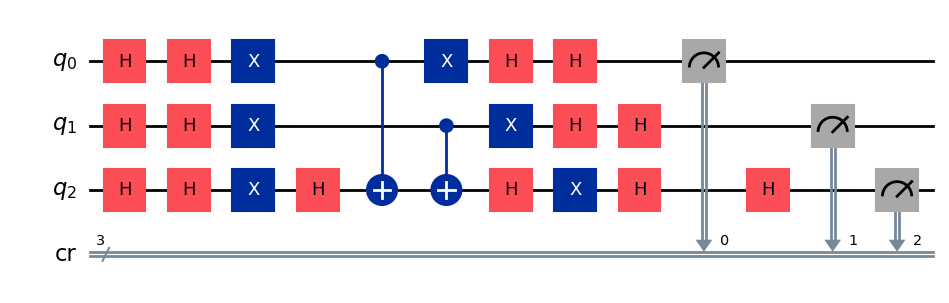

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 34] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


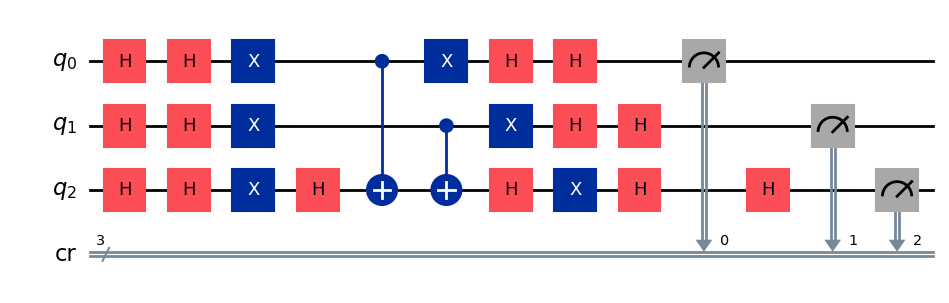

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 35] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


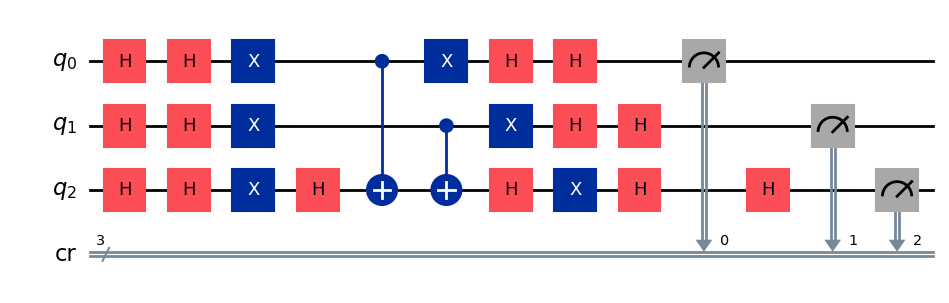

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 36] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


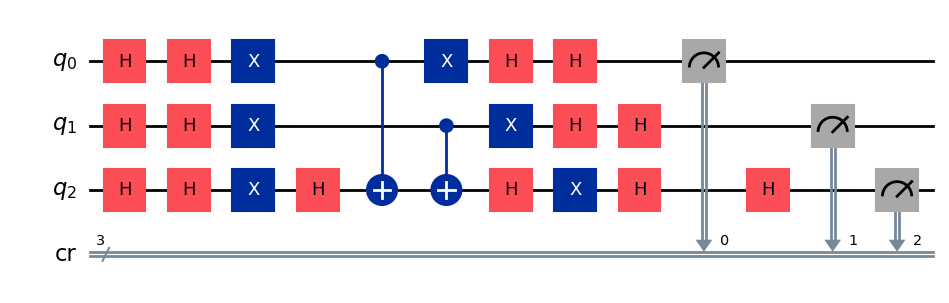

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 1

[Generation 37] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


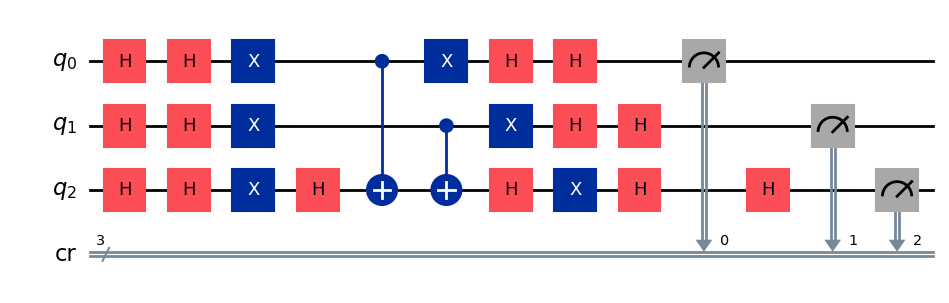

gen = 0 , Best fitness = (0.5,)


/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 38] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


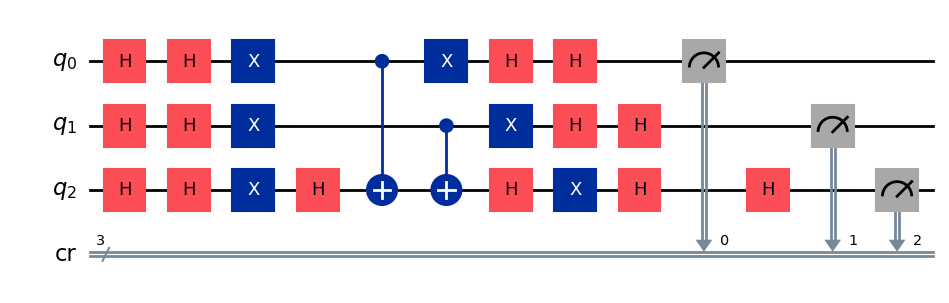

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 39] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


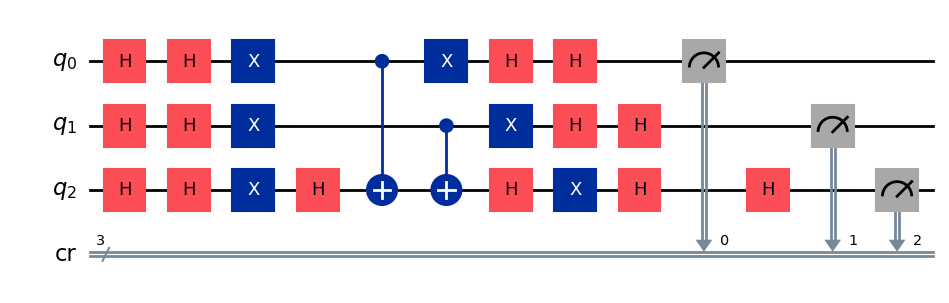

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 40] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


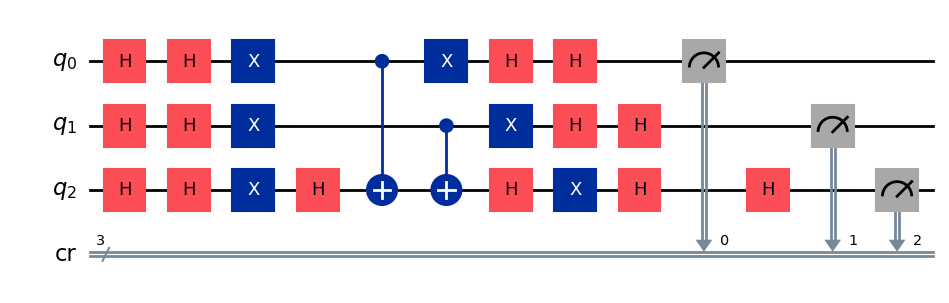

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 41] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


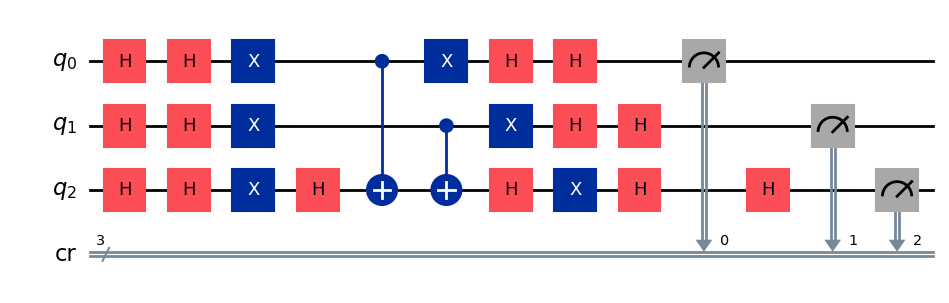

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 42] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


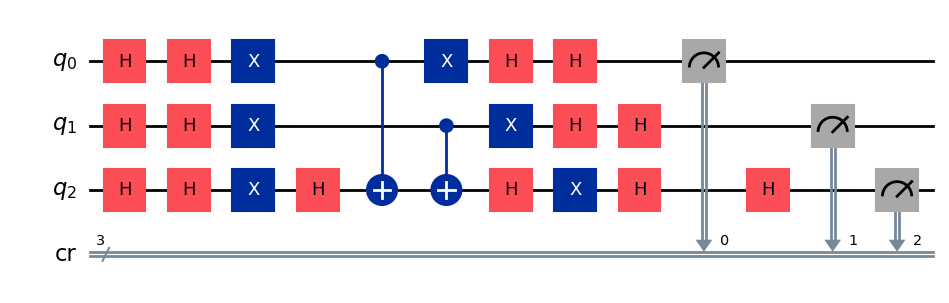

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 43] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


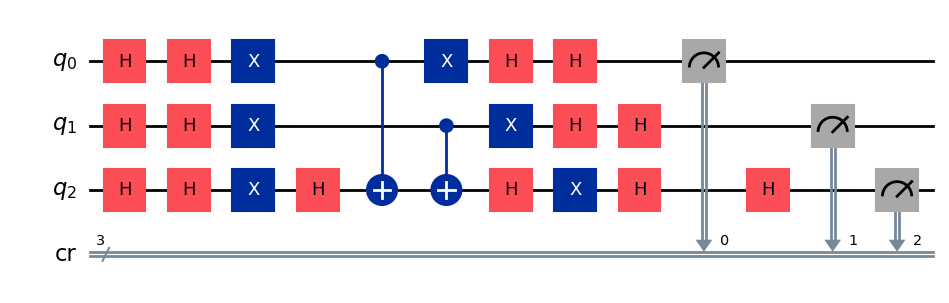

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 44] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


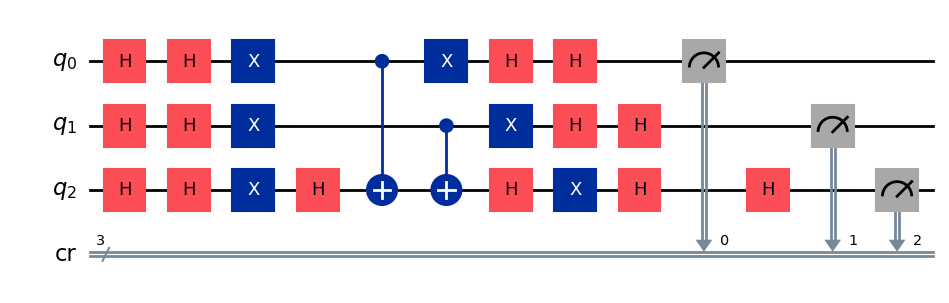

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 45] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


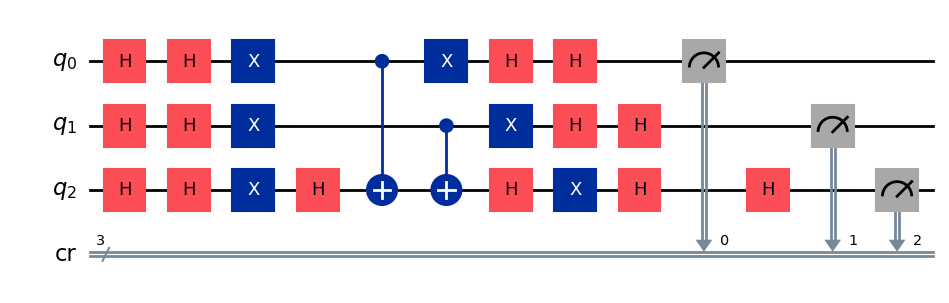

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 46] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


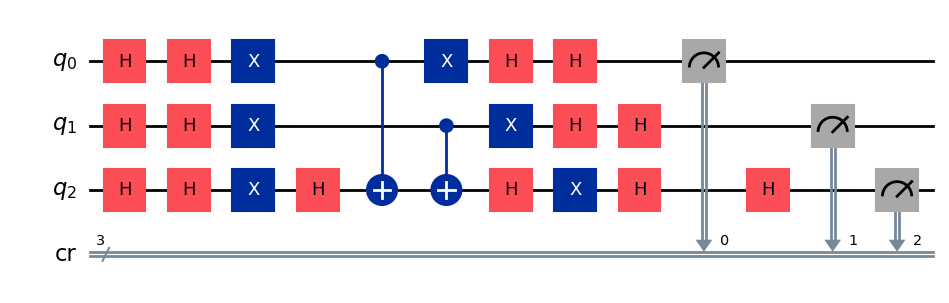

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 47] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


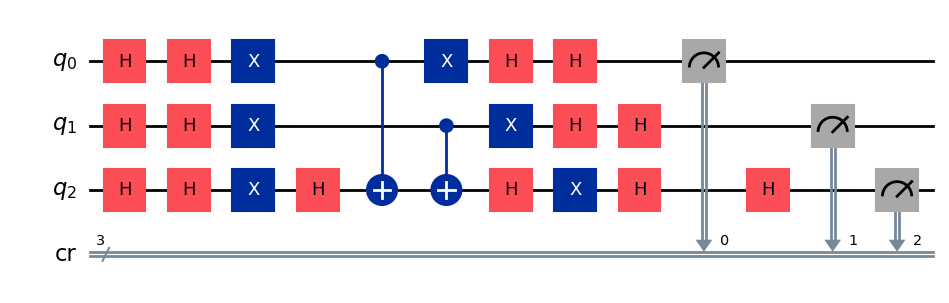

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 48] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


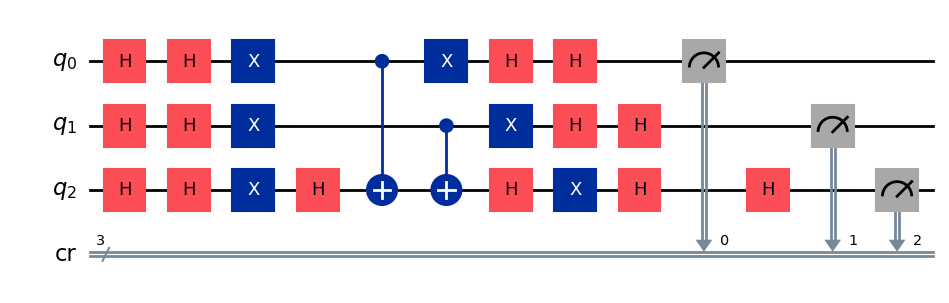

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 49] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


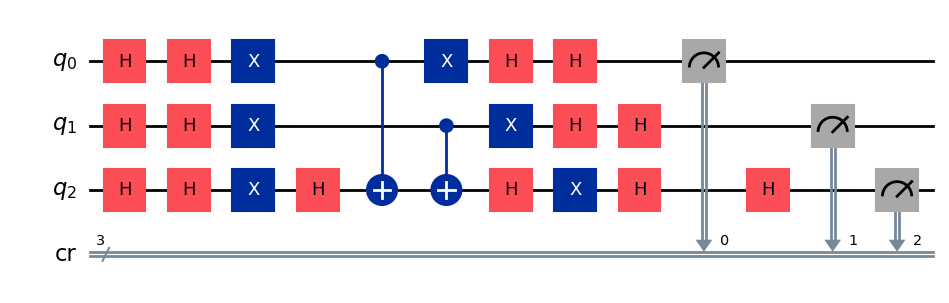

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 50] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


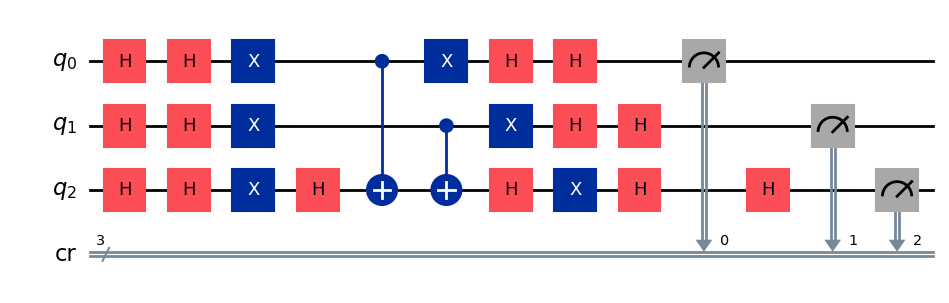

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 51] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


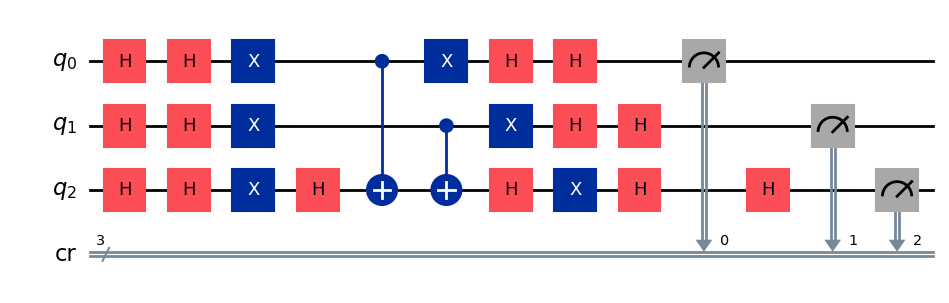

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 52] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


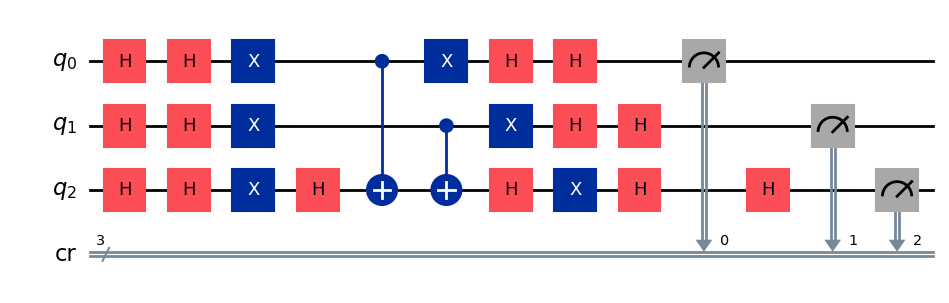

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 53] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


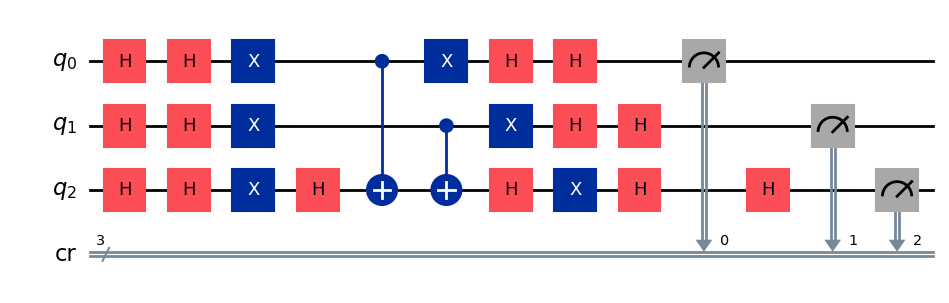

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 54] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


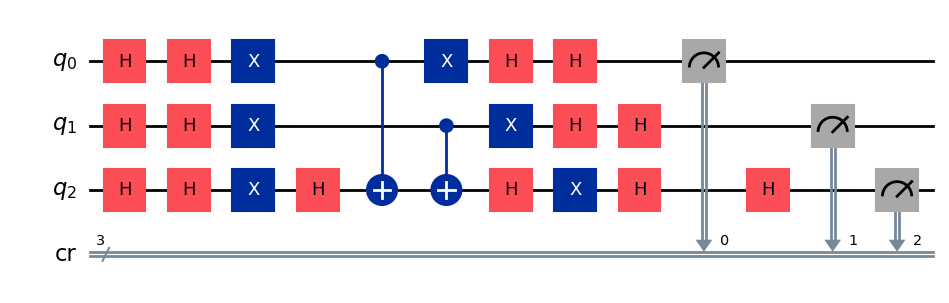

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 55] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


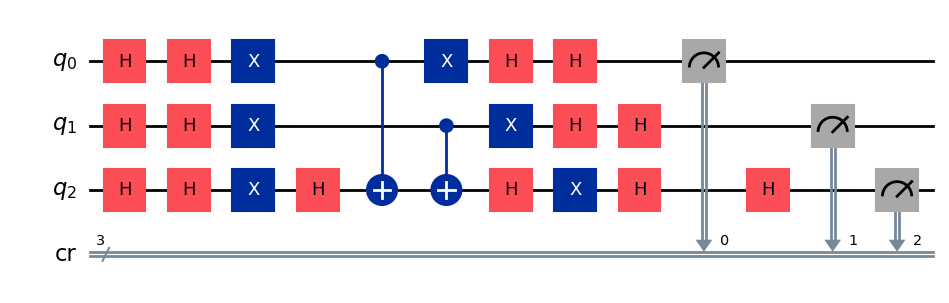

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 56] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


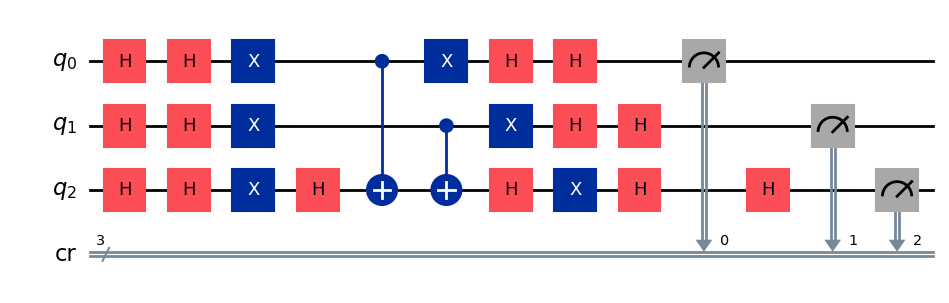

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 57] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


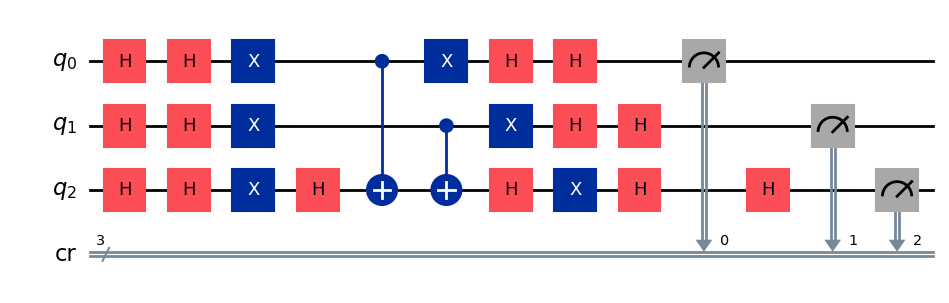

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 58] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


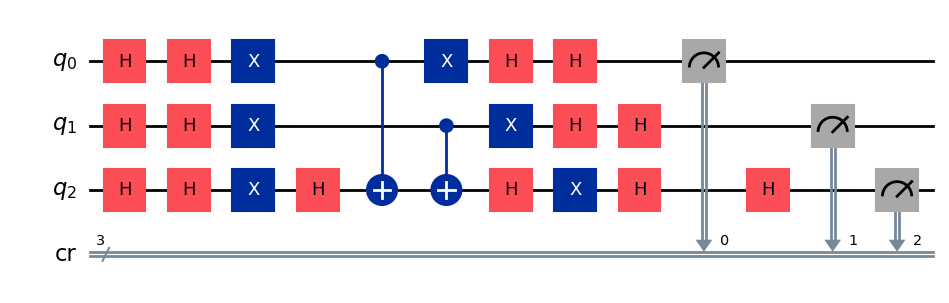

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 59] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


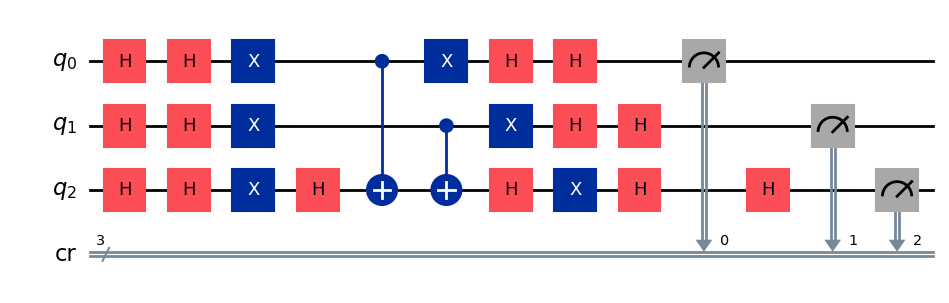

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 60] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


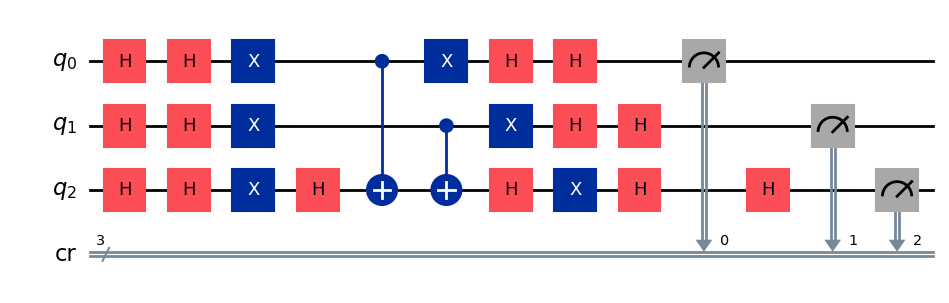

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 61] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


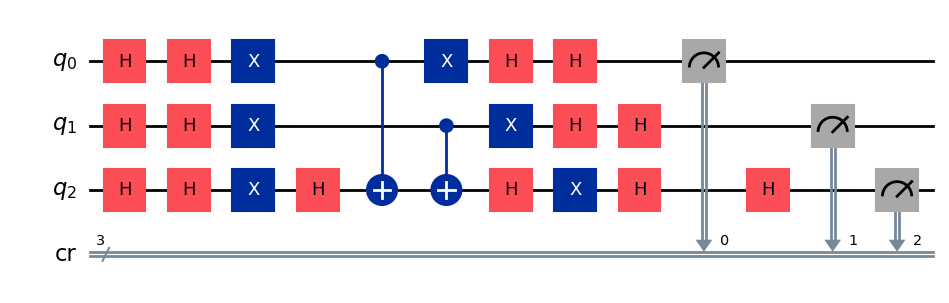

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 62] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


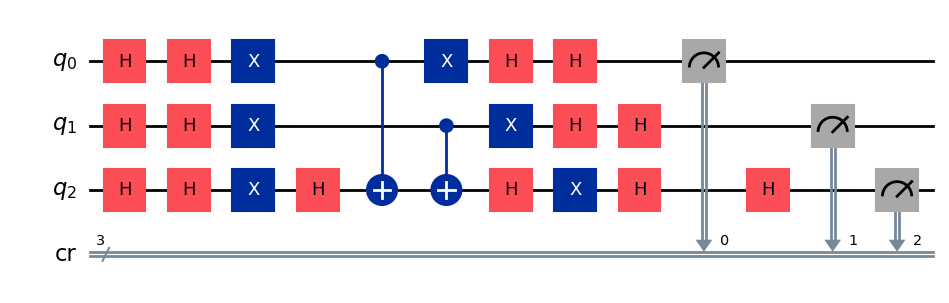

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 63] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


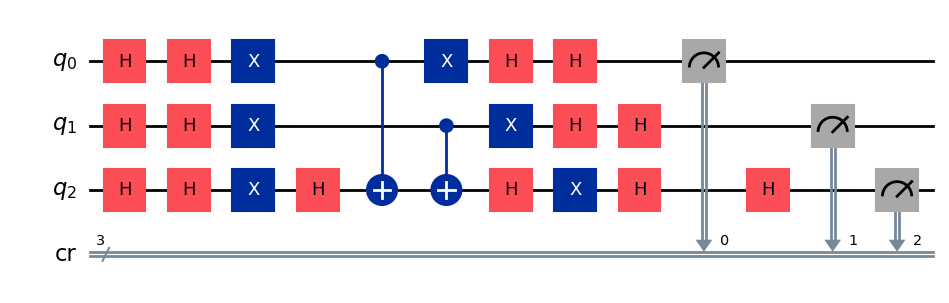

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 64] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


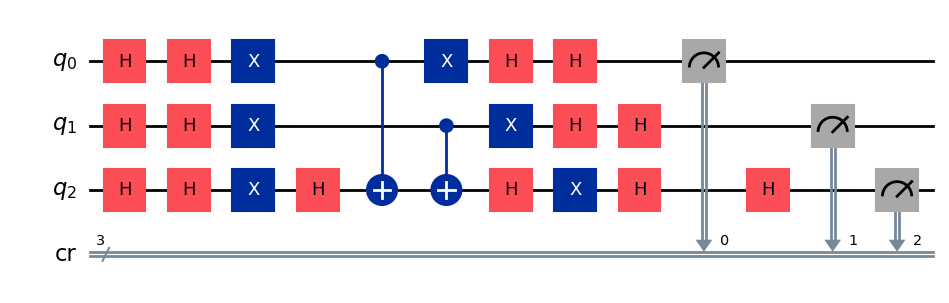

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 65] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


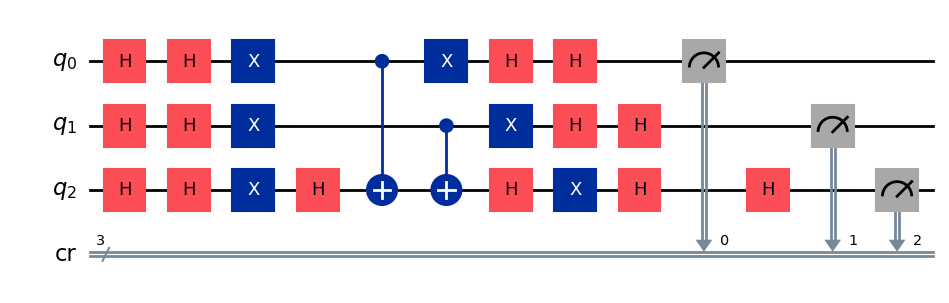

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 66] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


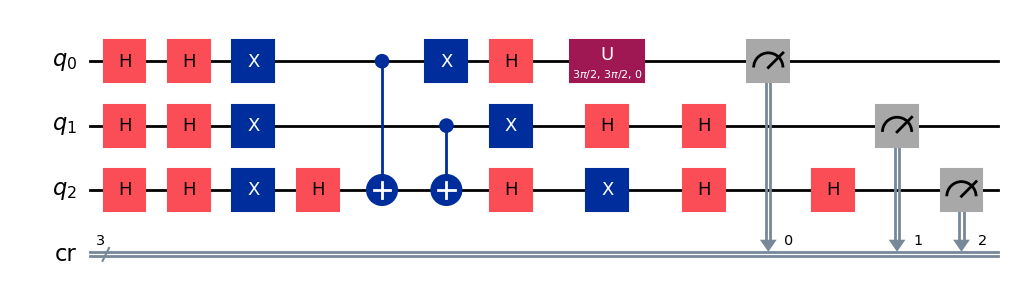

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 67] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


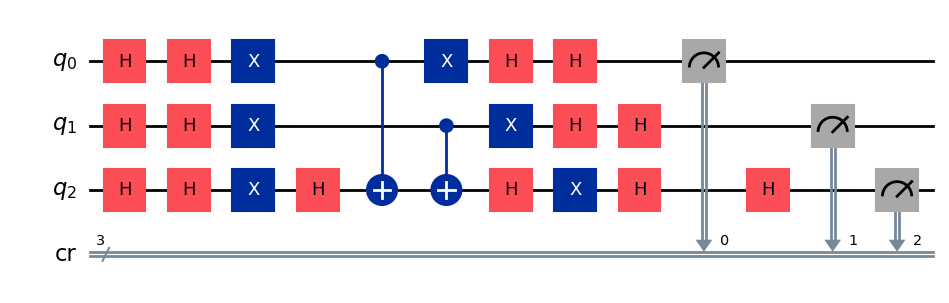

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 68] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


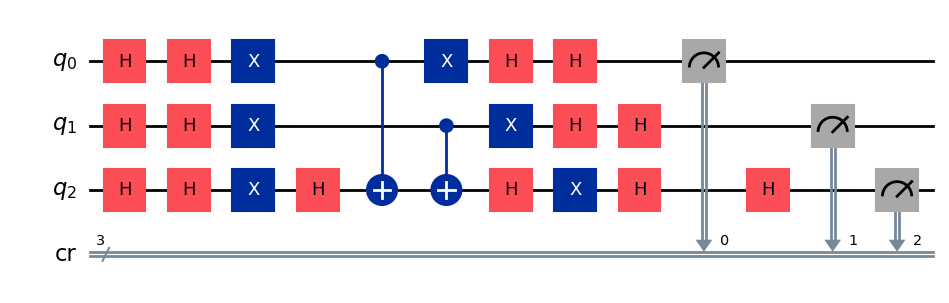

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 69] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


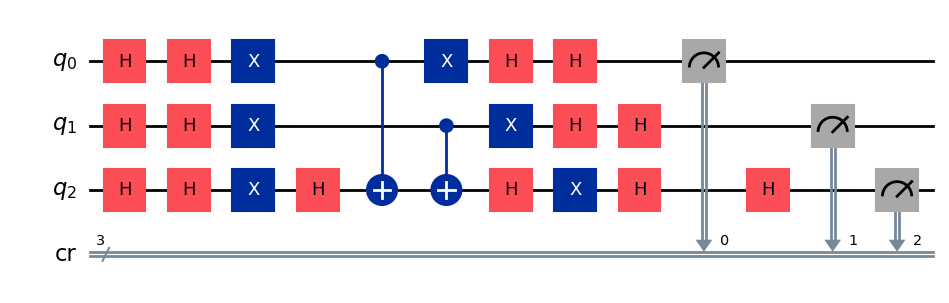

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 70] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


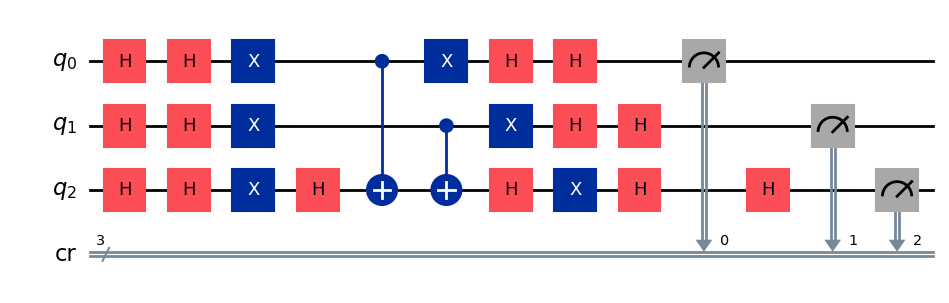

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 71] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


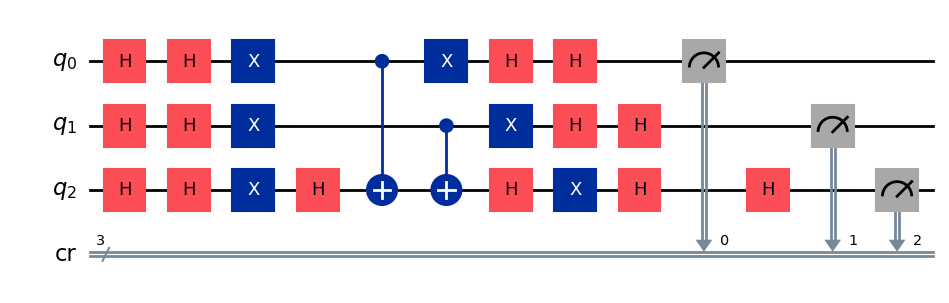

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 72] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


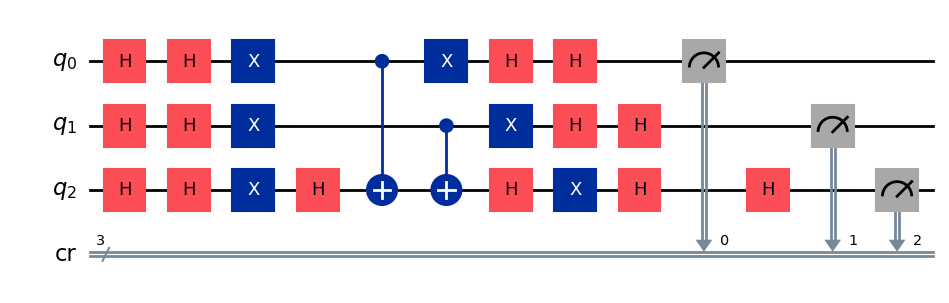

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 73] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


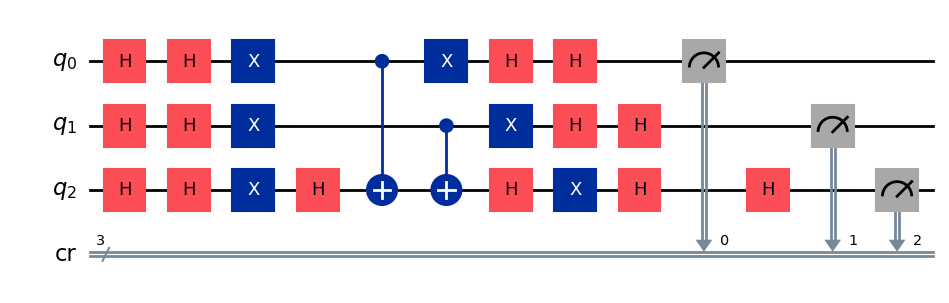

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 74] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


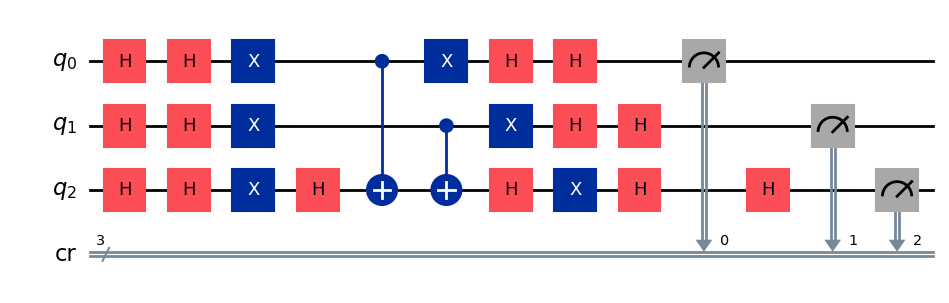

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 75] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


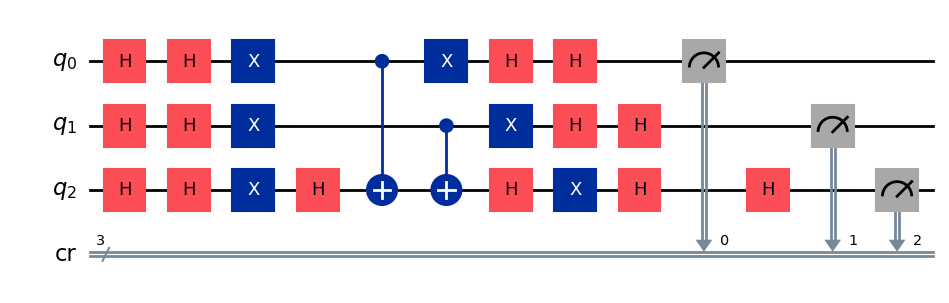

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 76] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


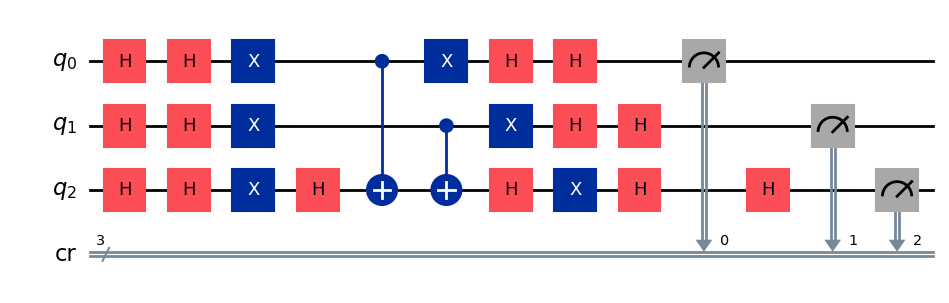

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 77] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


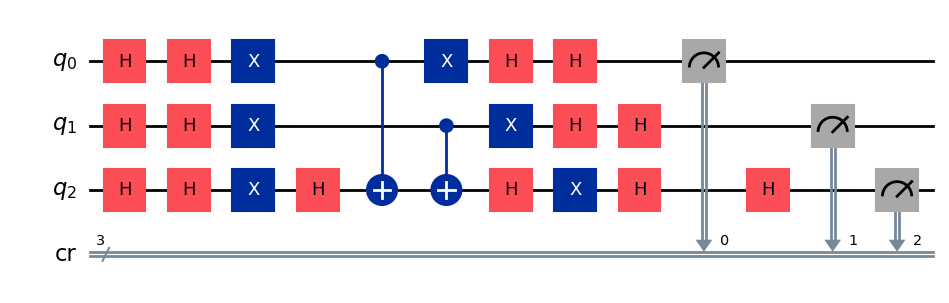

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 78] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


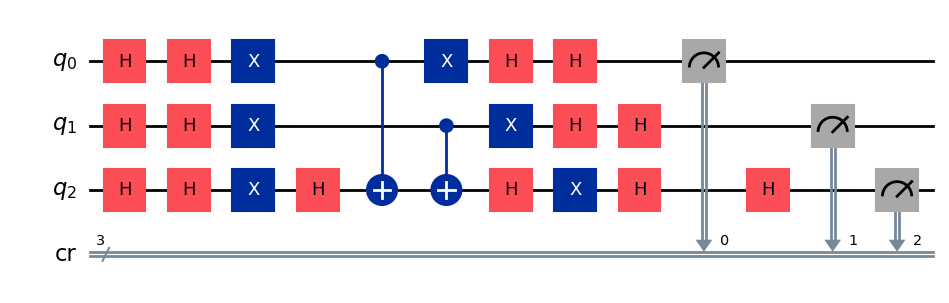

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 79] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


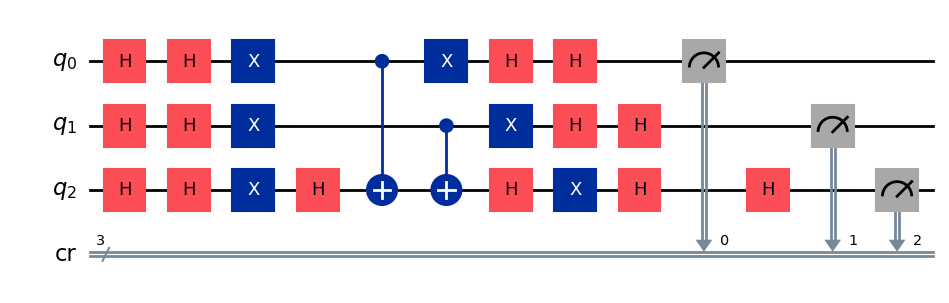

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 80] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


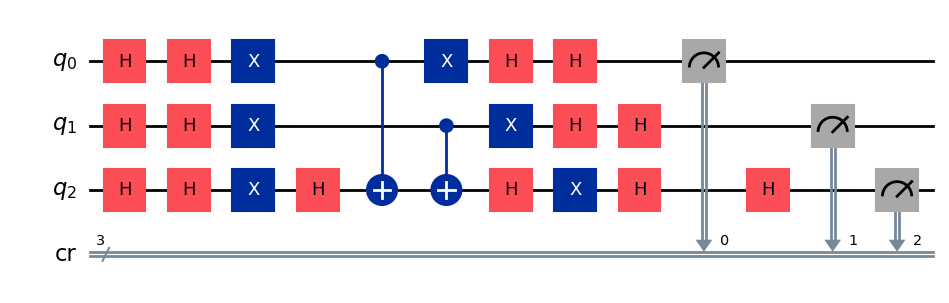

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 81] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


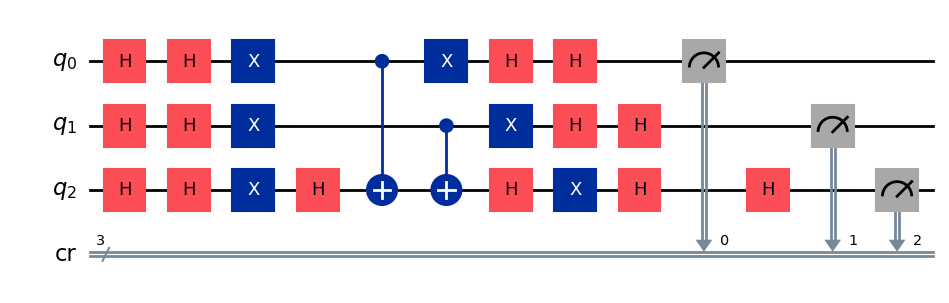

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 82] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


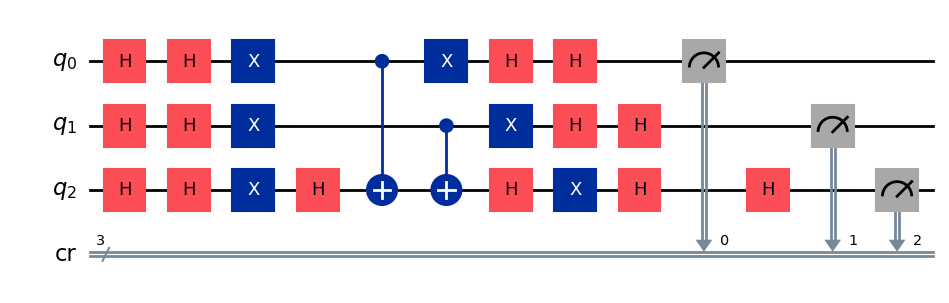

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 83] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


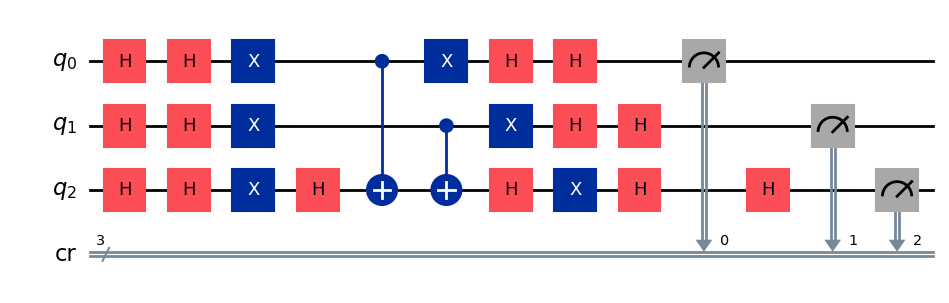

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 84] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


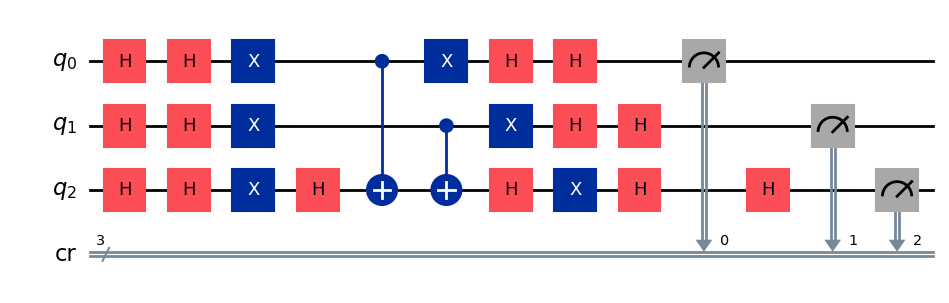

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 85] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


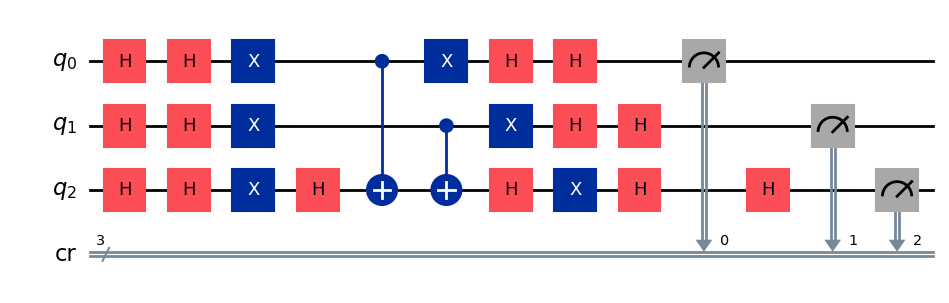

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 86] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


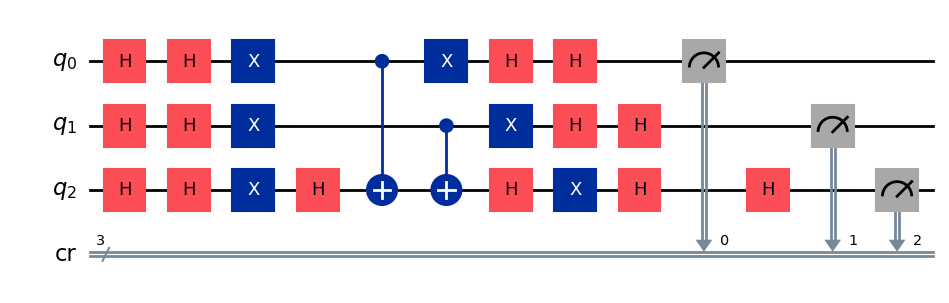

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 87] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


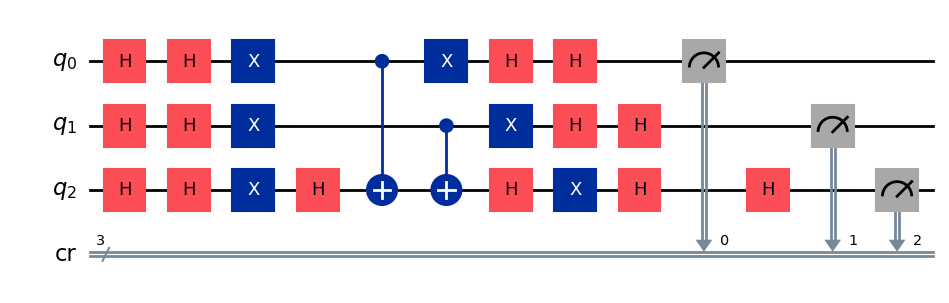

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 88] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


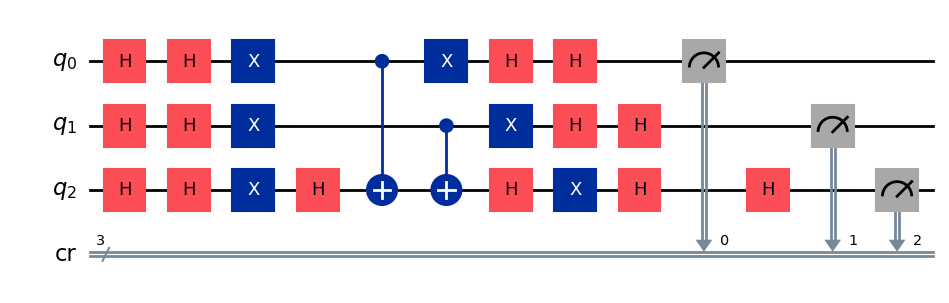

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 89] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


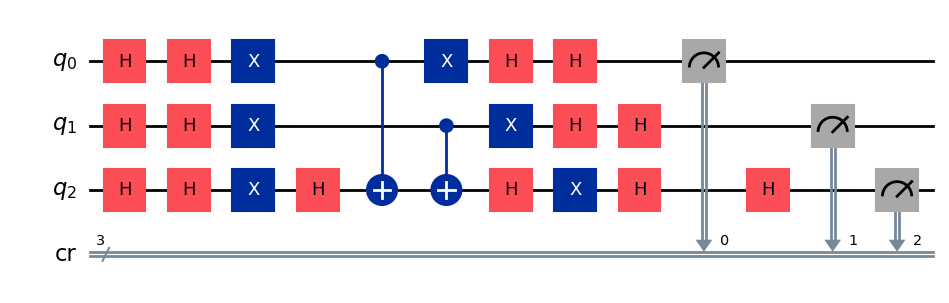

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 90] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


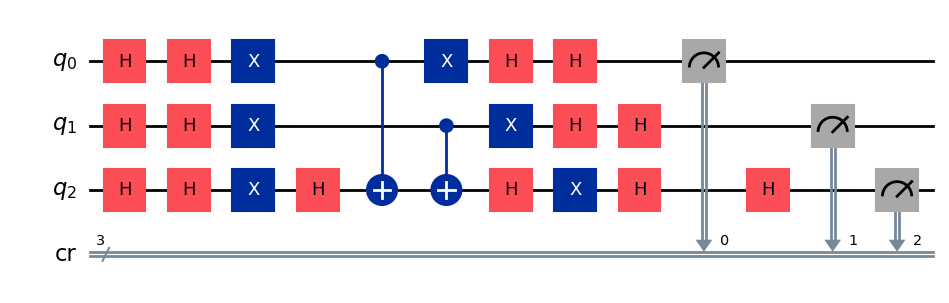

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 91] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


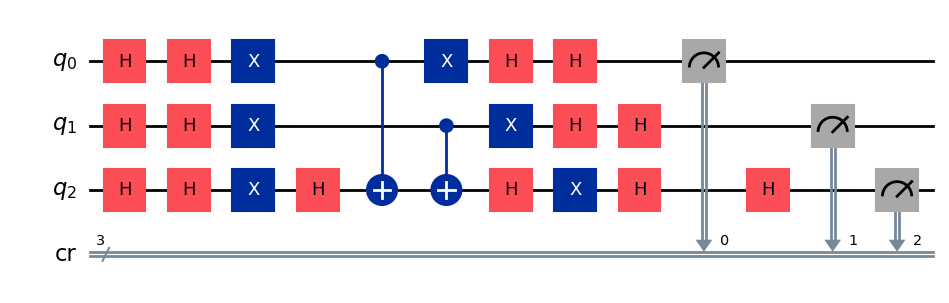

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 92] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


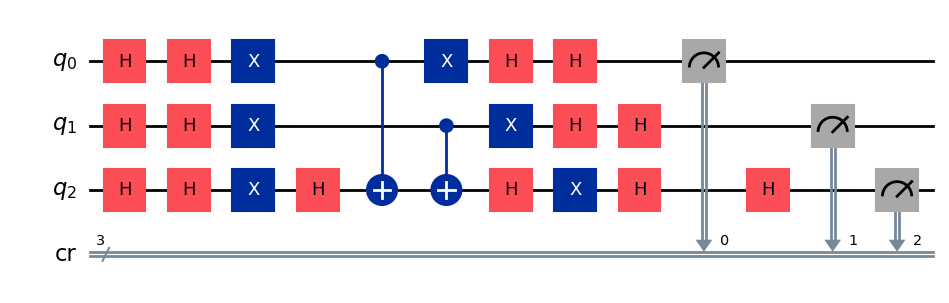

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 93] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


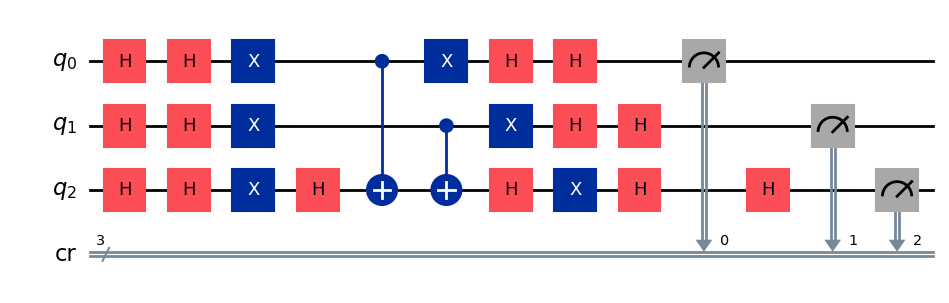

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 94] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


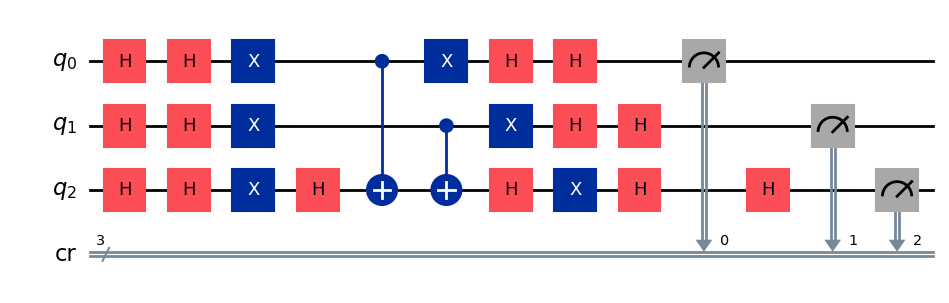

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 95] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


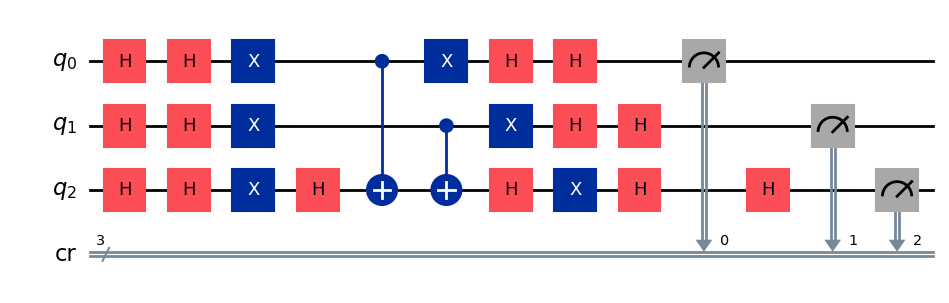

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 96] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


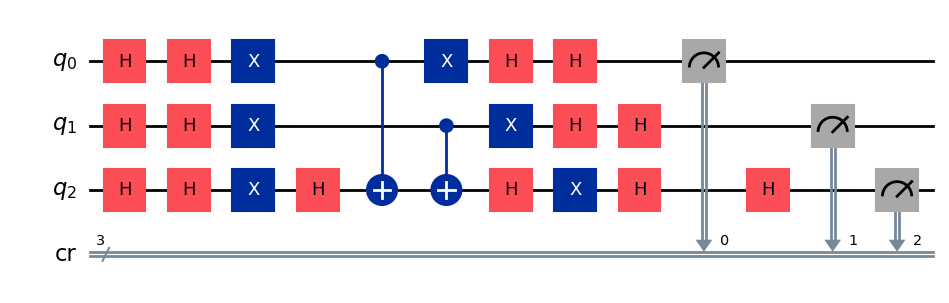

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 97] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


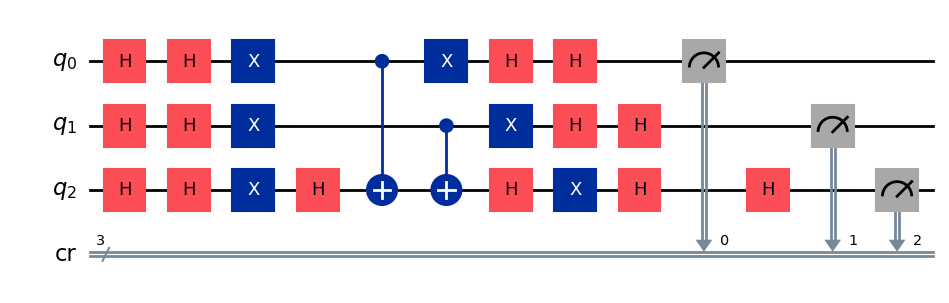

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 98] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


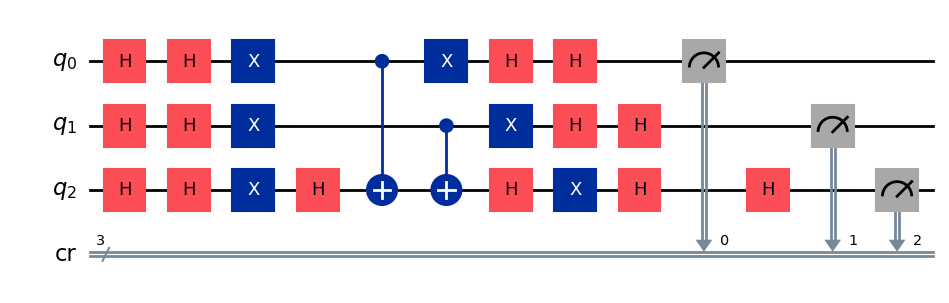

gen = 0 , Best fitness = (0.5,)
gen = 1 , Best fitness = (0.5,) , Number of invalids = 0

[Generation 99] Best Fitness: 0.5000
  Raw gates: 25, depth: 11
  p(marked): 1.0000
[Raw Circuit]


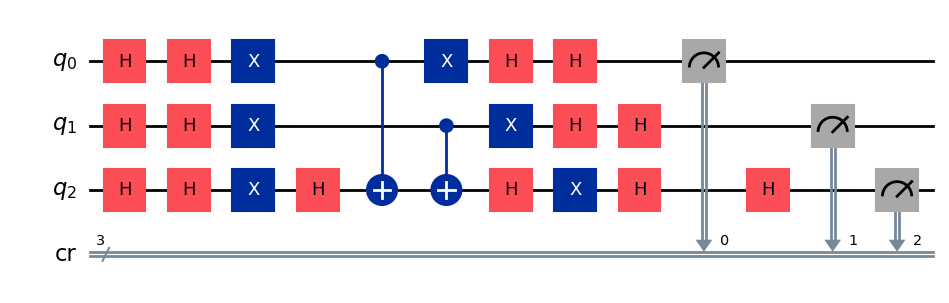


✓ Evolution complete!


In [17]:
print(f"\n{'='*60}")
print("STARTING EVOLUTION")
print(f"{'='*60}\n")

try:
    for gen in range(MAX_GENERATIONS):
        # Re-seed at the beginning of each generation for consistency
        random.seed(RANDOM_SEED + gen)
        
        # Run one generation
        population, logbook = algorithms.ge_eaSimpleWithElitism(
            population,
            toolbox,
            cxpb=P_CROSSOVER,
            mutpb=P_MUTATION,
            ngen=N_GEN,
            elite_size=ELITE_SIZE,
            bnf_grammar=BNF_GRAMMAR,
            codon_size=CODON_SIZE,
            max_tree_depth=MAX_TREE_DEPTH,
            codon_consumption=CODON_CONSUMPTION,
            report_items=['gen', 'invalid', 'avg', 'std', 'min', 'max'],
            genome_representation=GENOME_REPRESENTATION,
            stats=stats,
            halloffame=hof,
            verbose=False
        )

        # Get best individual
        best_ind = tools.selBest(population, 1)[0]
        best_ind.generation = gen

        # Evaluate best individual
        best_phenotype = evaluator.decode_individual(best_ind)
        if best_phenotype is not None:
            genome_hash = hash(tuple(best_ind.genome))
            individual_seed = (RANDOM_SEED + genome_hash) % (2**32)
            
            fitness_val, logs = fitness_function_qiskit(
                best_phenotype, 
                shots=NUM_SHOTS, 
                threshold=SUCCESS_THRESHOLD, 
                gate_penalty_weight=GATE_PENALTY_WEIGHT,
                target_state=TARGET_STATE, 
                log_states=True,
                individual_seed=individual_seed
            )
            best_fitness_list.append(fitness_val)
            
            if logs:
                avg_gate = np.mean([log["gate_count"] for log in logs])
                avg_depth = np.mean([log["depth"] for log in logs])
                p_marked = logs[0]["p_marked"]
            else:
                avg_gate = 0
                avg_depth = 0
                p_marked = 0
                
            avg_gate_count_list.append(avg_gate)
            generations_list.append(gen)

        # Display progress
        qc = evaluator.execute_circuit(best_phenotype)
        if qc:
            print(f"\n[Generation {gen}] Best Fitness: {best_ind.fitness.values[0]:.4f}")
            print(f"  Raw gates: {qc.size()}, depth: {qc.depth()}")
            print(f"  p(marked): {p_marked:.4f}")
            print("[Raw Circuit]")
            display(qc.draw("mpl"))
            plt.close()
                
            
except KeyboardInterrupt:
    print("\n" + "="*60)
    print("Evolution interrupted by user!")
    print("="*60)
    
except Exception as e:
    print(f"\nError during evolution: {e}")
    raise

finally:
    # Clean up multiprocessing pool
    if 'pool' in locals():
        pool.close()
        pool.join()

print("\n✓ Evolution complete!")

## Results Analysis


EVOLUTION RESULTS

[HALL OF FAME]

Individual 1:
  Fitness: 0.5000

Marked State: 000
  p(marked): 1.0000
  Error: 0.0000
  Gate Count: 25
  Depth: 11


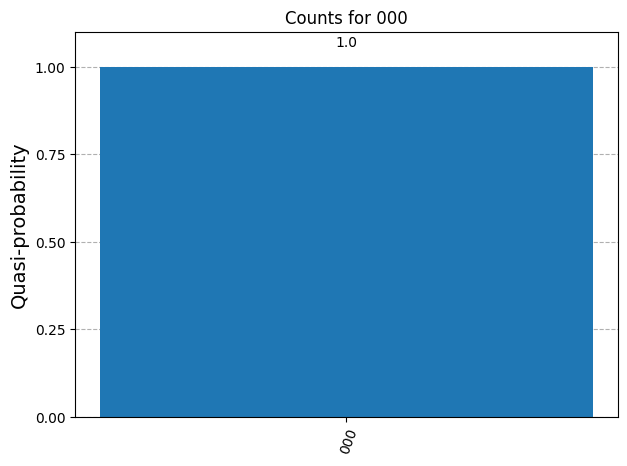


[Final Best Circuit]


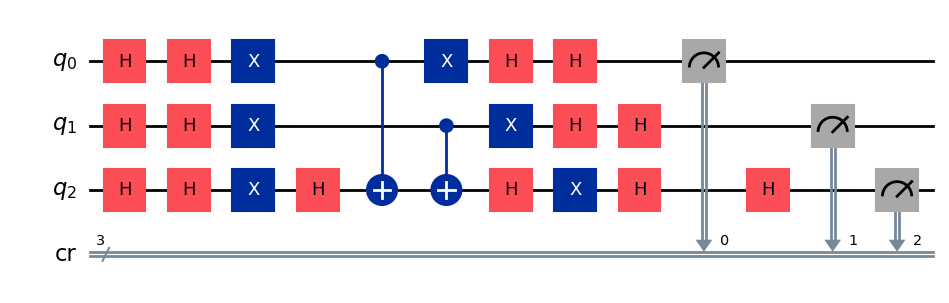


Best Individual's Fitness: 0.5000


In [18]:
# %%
print(f"\n{'='*60}")
print("EVOLUTION RESULTS")
print(f"{'='*60}")

# Display Hall of Fame
print("\n[HALL OF FAME]")
for i, hof_ind in enumerate(hof.items):
    print(f"\nIndividual {i+1}:")
    print(f"  Fitness: {hof_ind.fitness.values[0]:.4f}")

# Analyze best individual
best_ind = hof.items[0]
best_phenotype = evaluator.decode_individual(best_ind)

genome_hash = hash(tuple(best_ind.genome))
individual_seed = (RANDOM_SEED + genome_hash) % (2**32)

fitness, log_per_state = fitness_function_qiskit(
    best_phenotype, 
    log_states=True,
    individual_seed=individual_seed
)

evaluator.log_evaluation(log_per_state, MAX_GENERATIONS-1, best_ind)

for log_entry in log_per_state:
    print(f"\nMarked State: {log_entry['state']}")
    print(f"  p(marked): {log_entry['p_marked']:.4f}")
    print(f"  Error: {log_entry['error']:.4f}")
    print(f"  Gate Count: {log_entry['gate_count']}")
    print(f"  Depth: {log_entry['depth']}")
    
    fig = plot_distribution(log_entry["counts"], title=f"Counts for {log_entry['state']}")
    display(fig)
    plt.close()

# Display best circuit
best_circuit = evaluator.execute_circuit(best_phenotype)
if best_circuit:
    print(f"\n[Final Best Circuit]")
    display(best_circuit.draw("mpl"))
    plt.close()

print(f"\nBest Individual's Fitness: {best_ind.fitness.values[0]:.4f}")


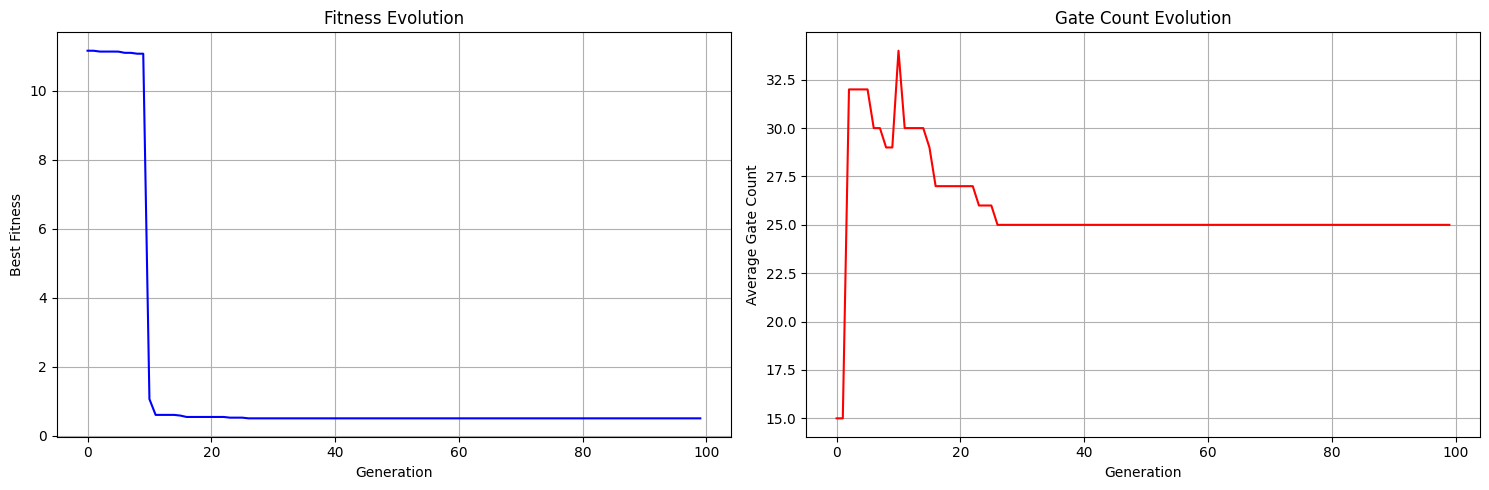

In [19]:
# Plot evolution progress
if generations_list and best_fitness_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Fitness over generations
    ax1.plot(generations_list, best_fitness_list, 'b-')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Best Fitness')
    ax1.set_title('Fitness Evolution')
    ax1.grid(True)
    
    # Gate count over generations
    ax2.plot(generations_list, avg_gate_count_list, 'r-')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Average Gate Count')
    ax2.set_title('Gate Count Evolution')
    ax2.grid(True)
    
    plt.tight_layout()
    display(fig)
    plt.close()

## IBM Quantum Hardware Execution

In [20]:
def run_hof_on_ibm(evaluator, hof, target_state=TARGET_STATE):
    """Run Hall of Fame individuals on IBM quantum hardware."""
    print(f"\n{'='*60}")
    print("IBM QUANTUM HARDWARE EXECUTION")
    print(f"{'='*60}")
    print(f"Target state: {target_state}")
    print(f"Shots per circuit: {evaluator.shots}")

    # Init IBM Runtime
    try:
        service = QiskitRuntimeService(channel="ibm_cloud", name="qgss-2025")
        backend = service.backend("ibm_brisbane")
        status = backend.status()
        print(f"✓ Connected to backend: {backend.name}")
        print(f"  Status: {status}")
    except Exception as e:
        print(f"✗ Could not connect to IBM backend: {e}")
        return

    sampler = Sampler(backend=backend)
    sampler.options.default_shots = evaluator.shots

    # Disable streaming callbacks
    try:
        sampler.options.environment.log_level = "WARNING"
        sampler.options.environment.callback = None
    except:
        pass

    for i, ind in enumerate(hof.items):
        print(f"\n[HOF Individual {i+1}] Fitness: {ind.fitness.values[0]:.4f}")

        pheno_code = evaluator.decode_individual(ind)
        if pheno_code is None:
            print("  ✗ Could not decode individual - skipping")
            continue

        circuit = evaluator.execute_circuit(pheno_code)
        if circuit is None:
            print("  ✗ Invalid circuit - skipping")
            continue

        print("\nOriginal circuit statistics:")
        print(f"  Gates: {circuit.size()}")
        print(f"  Depth: {circuit.depth()}")

        print("\nOriginal circuit:")
        display(circuit.draw("mpl"))
        plt.close()

        # Transpile for hardware
        print(f"\nTranspiling circuit for {backend.name}...")
        try:
            pm = generate_preset_pass_manager(
                target=backend.target,
                optimization_level=3,
                seed_transpiler=RANDOM_SEED
            )
            circuit_isa = pm.run(circuit)
            print("✓ Circuit transpiled successfully!")

            print("\nTranspiled circuit statistics:")
            print(f"  Gates: {circuit_isa.size()}")
            print(f"  Depth: {circuit_isa.depth()}")
            
            if circuit.size() > 0:
                print(f"  Gate change: {((circuit_isa.size() - circuit.size()) / circuit.size() * 100):+.1f}%")
                print(f"  Depth change: {((circuit_isa.depth() - circuit.depth()) / circuit.depth() * 100):+.1f}%")

            print("\nTranspiled circuit:")
            display(circuit_isa.draw(output="mpl", idle_wires=False))
            plt.close()
        except Exception as e:
            print(f"✗ Transpilation failed: {e}")
            continue

        # Submit job
        print(f"\nSubmitting job to {backend.name}...")
        print(f"  Requested shots: {evaluator.shots}")

        try:
            job = sampler.run([circuit_isa])
            print("✓ Job submitted")
            print(f"  Job ID: {job.job_id()}")
            print("  Waiting for results...")

            result = job.result(timeout=1800)

            # Extract counts
            data_bin = result[0]["__value__"]["data"]
            counts = data_bin.cr.get_counts()
            counts = {k[::-1]: v for k, v in counts.items()}

            # Calculate metrics
            total = sum(counts.values())
            p_marked = counts.get(target_state, 0) / total if total > 0 else 0.0

            print(f"\n✓ Hardware execution completed!")
            print(f"  Total shots: {total}")
            print(f"  Hardware p(marked): {p_marked:.4f}")

            # Display distribution
            fig = plot_distribution(counts, title=f"HOF #{i+1} on {backend.name}")
            display(fig)
            plt.close()

            # Compare to simulation
            evolution_fitness = ind.fitness.values[0]
            error_hw = 1 - p_marked
            miss_hw = 1 if error_hw > SUCCESS_THRESHOLD else 0
            gate_penalty_hw = GATE_PENALTY_WEIGHT * circuit_isa.size()
            fitness_hw = 10 * miss_hw + error_hw + gate_penalty_hw

            print("\nPerformance comparison:")
            print(f"  Simulation fitness: {evolution_fitness:.4f}")
            print(f"  Hardware fitness: {fitness_hw:.4f}")
            
            if fitness_hw < evolution_fitness:
                print(f"  ✓ Hardware better by: {(evolution_fitness - fitness_hw):.4f}")
            else:
                print(f"  ✗ Hardware worse by: {(fitness_hw - evolution_fitness):.4f}")

            # Save results
            hw_data = {
                "individual_id": i + 1,
                "fitness_evolution": float(evolution_fitness),
                "fitness_hardware": float(fitness_hw),
                "backend": backend.name,
                "target_state": target_state,
                "counts": counts,
                "p_marked_hw": p_marked,
                "total_shots": total,
                "original_gates": circuit.size(),
                "original_depth": circuit.depth(),
                "transpiled_gates": circuit_isa.size(),
                "transpiled_depth": circuit_isa.depth(),
                "job_id": job.job_id(),
                "timestamp": datetime.now().isoformat(),
            }

            json_path = os.path.join(LOG_DIR, f"hof_{i+1}_hardware_results.json")
            with open(json_path, "w") as f:
                json.dump(hw_data, f, indent=2)
            print(f"  Results saved to: {json_path}")

        except Exception as e:
            print(f"✗ Hardware execution failed: {e}")
            continue

    print(f"\n{'='*60}")
    print("Hardware execution completed!")
    print(f"{'='*60}")

qiskit_runtime_service._discover_account:WARNING:2025-08-21 13:27:44,390: Loading account with name qgss-2025. Any input 'channel', 'token' or 'url' are ignored.



IBM QUANTUM HARDWARE EXECUTION
Target state: 000
Shots per circuit: 10000
✓ Connected to backend: ibm_brisbane
  Status: <qiskit.providers.models.backendstatus.BackendStatus object at 0x14650ce80>

[HOF Individual 1] Fitness: 0.5000

Original circuit statistics:
  Gates: 25
  Depth: 11

Original circuit:


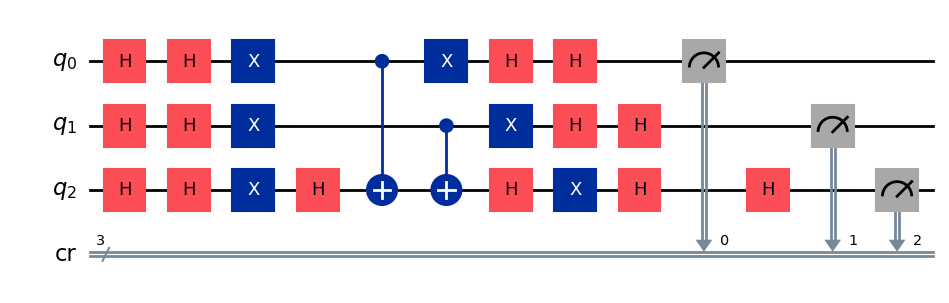


Transpiling circuit for ibm_brisbane...
✓ Circuit transpiled successfully!

Transpiled circuit statistics:
  Gates: 20
  Depth: 10
  Gate change: -20.0%
  Depth change: -9.1%

Transpiled circuit:


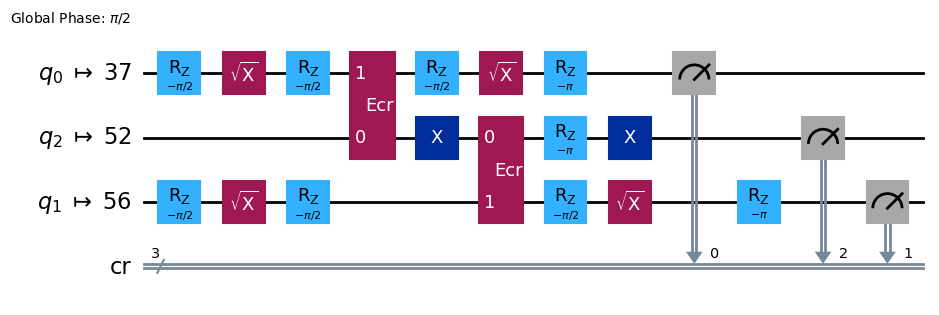


Submitting job to ibm_brisbane...
  Requested shots: 10000
✓ Job submitted
  Job ID: d2jh1hsg59ks73c3o5tg
  Waiting for results...


base_runtime_job._start_websocket_client:WARNING:2025-08-21 13:33:09,131: An error occurred while streaming results from the server for job d2jh1hsg59ks73c3o5tg:
Traceback (most recent call last):
  File "/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/base_runtime_job.py", line 314, in _start_websocket_client
    self._ws_client.job_results()
  File "/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/Users/caephas/Downloads/LERO/Grammatical-Evolution-for-Quantum-Algorithms/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/api/clients/base_websocket_client.py", line 222, in stream
    raise WebsocketError(error_message)
qiskit_ibm_runtime.api.exceptions.WebsocketError: 'Max retries exceeded


✓ Hardware execution completed!
  Total shots: 10000
  Hardware p(marked): 0.9451


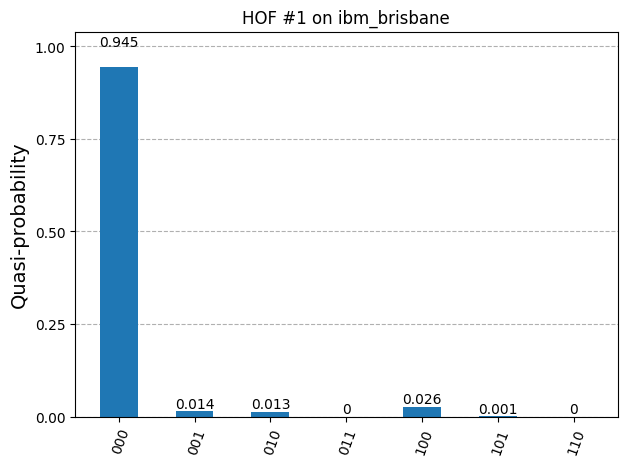


Performance comparison:
  Simulation fitness: 0.5000
  Hardware fitness: 0.4549
  ✓ Hardware better by: 0.0451
  Results saved to: logs_marked_state_IBM_000_ibm_brisbane/hof_1_hardware_results.json

Hardware execution completed!


In [21]:
run_hof_on_ibm(evaluator, hof, target_state=TARGET_STATE)